## Returning to brute force
First, I want to compare `adaptive` sampling of the ink gamut compared to brute force sampling.

I'll start with CMY ink gamut in LMS space

In [4]:
import csv
import numpy as np
from spectra import Spectra, Pigment
import matplotlib.pyplot as plt
import numpy.typing as npt
import torch as th

In [2]:
from inks import load_neugebauer, InkGamut

In [5]:
from observer import Observer, Cone
from inks import Neugebauer, InkGamut, find_best_ns

In [6]:
l_cone = Cone.l_cone()
m_cone = Cone.m_cone()
q_cone = Cone.q_cone()
s_cone = Cone.s_cone()
trichromat = Observer.trichromat()
tetrachromat = Observer.tetrachromat()

In [43]:
import colour
colour_d50 = colour.SDS_ILLUMINANTS.get('D50')
d50 = Spectra(data=colour_d50.values / 103.003, wavelengths=colour_d50.wavelengths)

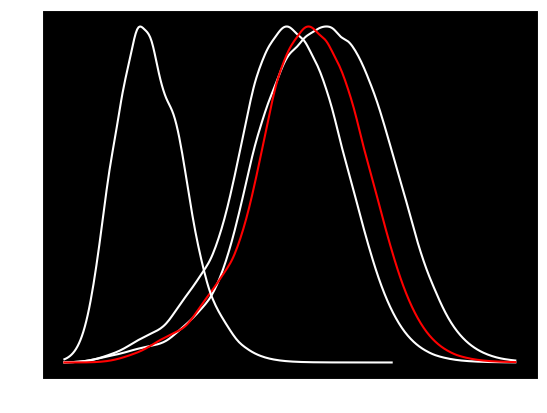

In [51]:

fig, axb = plt.subplots()
# fig.patch.set_facecolor('black')
axb.set_facecolor('black')

for spine in axb.spines.values():
    spine.set_color('white')

# Set the color of the ticks and labels
axb.tick_params(colors='white', which='both')  # 'both' applies the style to both major and minor ticks

# Set the color of the axis labels
axb.xaxis.label.set_color('white')
axb.yaxis.label.set_color('white')


l_cone.plot(color='white',ax=axb)
m_cone.plot(color='white', ax=axb)
q_cone.plot(color='red', ax=axb)
s_cone.plot(color='white',ax=axb)
fig.savefig("lqms_bw.png", transparent=True)
plt.show()

In [18]:
cmy_primaries_dict = {}
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

primary_fns = [
    "000",
    "001",
    "010",
    "100",
    "011",
    "110",
    "101",
    "111",
]

for fn in primary_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths10)
                cmy_primaries_dict[fn] = spectra

In [19]:
paper = cmy_primaries_dict["000"]

In [20]:
cmy_neugebauer = Neugebauer(cmy_primaries_dict)

In [21]:
trichromat_observe1 = trichromat.get_sensor_matrix(wavelengths1)
trichromat_observe10 = trichromat.get_sensor_matrix(wavelengths10)

trichromat_observe10 = trichromat.get_sensor_matrix(wavelengths10)
tetrachromat_observe10 = tetrachromat.get_sensor_matrix(wavelengths10)

## Helper methods

### plot pointcloud

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

def plot_pointcloud_hull(points, labels=('S','M','L'), fig=None, ax=None, alpha=1, plot_points=False):
    # points in shape M x 3
    hull = ConvexHull(points)
    
    if fig is None or ax is None:  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])    
    
    for simplex in hull.simplices:
        s = simplex.astype(int)
        s = np.append(s, s[0])  # Loop back to the first point to close the simplex
        ax.plot(points[s, 0], points[s, 1], points[s, 2], "k-", alpha=alpha)
    
    if plot_points:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', alpha=alpha)
    
    return fig, ax

### bucketing

In [9]:
from collections import defaultdict

def bucket_points(points, axis=2):
    buckets = defaultdict(list)

    for idx, point in enumerate(points):
        key = tuple([round(c, 2) for i, c in enumerate(point) if i != axis])
        value = (tuple(point), idx)
        buckets[key].append(value)
        
    return buckets

def max_dist(buckets, axis=2):
    max_dist = 0
    best_indices = None, None
    for metamers in buckets.values():
        if len(metamers) <= 1:
            continue

        axis_values = [metamer[0][axis] for metamer in metamers]

        min_val = min(axis_values)
        max_val = max(axis_values)

        distance = max_val - min_val

        if distance > max_dist:
            max_dist = distance

            min_index = axis_values.index(min_val)
            max_index = axis_values.index(max_val)

            best_indices = (metamers[min_index][1], metamers[max_index][1])

    return max_dist, best_indices        
        

### KM interpolation code

todo: pass in known/measured primaries 

In [10]:
def k_s_from_pigments(pigments):
    k_list = []
    s_list = []

    for pigment in pigments:
        if not isinstance(pigment, Pigment):
            pigment = Pigment(reflectance=pigment)
        k, s = pigment.get_k_s()
        k_list.append(k)
        s_list.append(s)

    k_matrix = np.column_stack(k_list)
    s_matrix = np.column_stack(s_list)

    return k_matrix, s_matrix

def km_mix(pigments , concentrations = None):
    K_matrix, S_matrix = k_s_from_pigments(pigments)
    wavelengths = pigments[0].wavelengths()

    if not concentrations:
        concentrations = np.array([1 / len(pigments)] * len(pigments) )
        
    K_mix = K_matrix @ concentrations
    S_mix = S_matrix @ concentrations / (len(pigments) ** 2) # varuns secret correction term
    
    k = np.column_stack((wavelengths, K_mix))
    s = np.column_stack((wavelengths, S_mix))
    
    return Pigment(k=k , s=s )

def load_neugebauer(inks, paper):
    num_inks = len(inks)
    primaries_dict = {}
    primaries_dict['0' * num_inks] = paper
    
    for i in range(1, 2 ** num_inks): 
        binary_str = format(i, f'0{num_inks}b')  
        inks_to_mix = []

        for j, bit in enumerate(binary_str):
            if bit == '1':
                inks_to_mix.append(inks[j])
        
        if binary_str not in primaries_dict: # might not need if statement
            mixed_ink = km_mix(inks_to_mix)
            primaries_dict[binary_str] = mixed_ink
    return Neugebauer(primaries_dict)

### `get_point_cloud` and `gamut_width`

In [11]:
from itertools import product

from tqdm.notebook import tqdm

def get_point_cloud(ink_neugebauer, observe, whitepoint=None, stepsize=0.1):
    if whitepoint is None:
        whitepoint = np.matmul(observe, np.ones(observe.shape[1]))
    point_cloud = []
    _percentages = []
    values = np.arange(0, 1 + stepsize, stepsize)
    # Wrap the iterable with tqdm for a progress bar
    total_combinations = (len(values) ** ink_neugebauer.num_inks)
    for percentages in tqdm(product(values, repeat=ink_neugebauer.num_inks), total=total_combinations, desc='Generating Point Cloud'):
        stimulus = ink_neugebauer.observe(np.array(percentages), observe, whitepoint)
        point_cloud.append(stimulus)
        _percentages.append(percentages)
    return np.array(point_cloud), np.array(_percentages)

def gamut_width(inks, paper, observe, whitepoint=None, stepsize=0.1, save=False):
    neugebauer = load_neugebauer(inks, paper)
    point_cloud, percentages = get_point_cloud(neugebauer, observe, whitepoint, stepsize=stepsize)
    print("Point cloud generated.")
    
    if save:
        np.save(f"{save}_point_cloud{int(100 * stepsize)}", point_cloud)
        np.save(f"{save}_percentages{int(100 *stepsize)}", percentages)
        print("Point cloud saved.")
    
    buckets = bucket_points(point_cloud)
    
    dst, (i, j) = max_dist(buckets)
    
    print(f"maximum distance is {dst}")
    print(f"with percentages {percentages[i]} and  {percentages[j]}")
    return dst


## Jessica's pigments

### Candidate pigments

In [22]:
candidate_pigments = np.load("npy/candidate_pigments.npy")

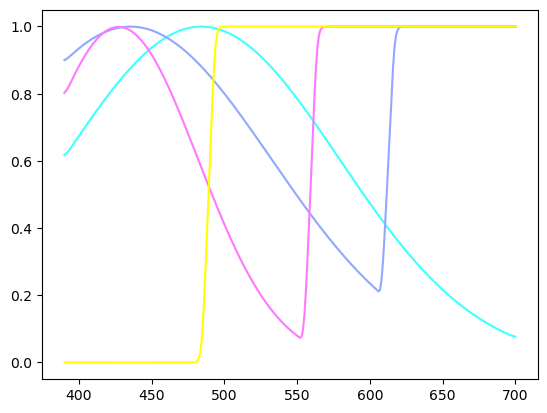

In [23]:
optimal_inks = []
fig, ax = plt.subplots()
for candidate in candidate_pigments:
    spectra = Spectra(data=np.clip(candidate, 0, 1), wavelengths=wavelengths1)
    optimal_inks.append(spectra.interpolate_values(wavelengths10))
    spectra.plot(ax=ax)
plt.show()

In [29]:
optimal_neug = load_neugebauer(optimal_inks, paper)
optimal_gamut = InkGamut(optimal_neug)

In [30]:
optimal_gamut.get_width(tetrachromat)

AttributeError: 'NoneType' object has no attribute 'T'

In [69]:
np.arange(390,700,1
        )

array([390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
       481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493,
       494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506,
       507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
       520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532,
       533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545,
       546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558,
       559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 57

In [24]:
gamut_width(optimal_inks, paper, tetrachromat_observe10)

NameError: name 'gamut_width' is not defined

### Optimal pigments

In [32]:
optimal_pigments = np.load("npy/optimal_pigments.npy")

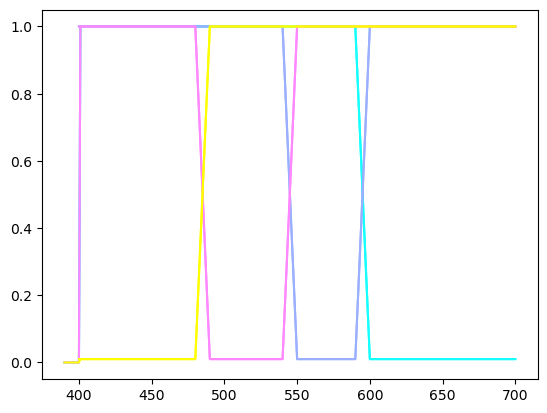

In [67]:
optimal_spectras = []
optimal_spectras10 = []
optimal_spectras_upscaled = []
fig2, ax2 = plt.subplots()
for pigment in optimal_pigments:
    spectra = Spectra(data=np.clip(pigment, 0.01, 1), wavelengths=wavelengths1)
#     spectra.plot(ax=ax2, alpha=0.5)
    optimal_spectras.append(spectra)
    
    spectra10 = spectra.interpolate_values(wavelengths10)
    spectra10.plot(ax=ax2)
    optimal_spectras10.append(spectra10)

    spectra1 = spectra10.interpolate_values(wavelengths1)
    spectra1.plot(ax=ax2)
    optimal_spectras_upscaled.append(spectra1)
    
plt.show()

lol! That's funny

In [63]:
neug1 = load_neugebauer(optimal_spectras, paper=paper.interpolate_values(wavelengths1))
neug10 = load_neugebauer(optimal_spectras10, paper=paper)
neug_upscaled = load_neugebauer(optimal_spectras_upscaled, paper=paper.interpolate_values(wavelengths1))

In [64]:
gamut1 = InkGamut(neug1, illuminant=d50)
gamut10 = InkGamut(neug10,  illuminant=d50)
gamut_upscaled = InkGamut(neug_upscaled, illuminant=d50)

In [56]:
neug10.spectras_array.shape

(16, 31)

In [66]:
neug_upscaled.spectras_array.shape

(16, 311)

In [59]:
gamut1.get_width(tetrachromat, stepsize=0.02)

[  44.74102779   90.0488655    90.43921467  110.26409384]


Generating Point Cloud: 100%|███████████| 6765201/6765201 [01:51<00:00, 60759.97it/s]


Point cloud generated.
maximum distance is 0.12162161309405184 with percentages (0.02, 1.0, 0.02, 0.12) and (0.56000000000000005, 0.0, 0.97999999999999998, 0.059999999999999998)


0.12162161309405184

In [60]:
gamut10.get_width(tetrachromat, stepsize=0.02)

[  4.48575988   9.00487457   9.04759828  11.02469504]


Generating Point Cloud: 100%|███████████| 6765201/6765201 [01:26<00:00, 78487.08it/s]


Point cloud generated.
maximum distance is 0.11682919701751188 with percentages (0.12, 0.97999999999999998, 0.040000000000000001, 0.14000000000000001) and (1.0, 0.0, 0.90000000000000002, 0.10000000000000001)


0.11682919701751188

In [65]:
gamut_upscaled.get_width(tetrachromat, stepsize=0.02)

[  44.74102779   90.0488655    90.43921467  110.26409384]


Generating Point Cloud: 100%|███████████| 6765201/6765201 [01:51<00:00, 60807.28it/s]


Point cloud generated.
maximum distance is 0.11131101193876147 with percentages (0.14000000000000001, 1.0, 0.0, 0.14000000000000001) and (0.95999999999999996, 0.0, 0.62, 0.10000000000000001)


0.11131101193876147

In [29]:
optimal_neugebauer = load_neugebauer(optimal_spectras, paper.interpolate_values(wavelengths1))

In [163]:
a = Spectra(data=optimal_neugebauer.mix(th.tensor([0, 0.95, 0, 0.25])).T, wavelengths=wavelengths1)

In [164]:
b = Spectra(data=optimal_neugebauer.mix(th.tensor([0.35, 0, 0.6, 0.15])).T, wavelengths=wavelengths1)

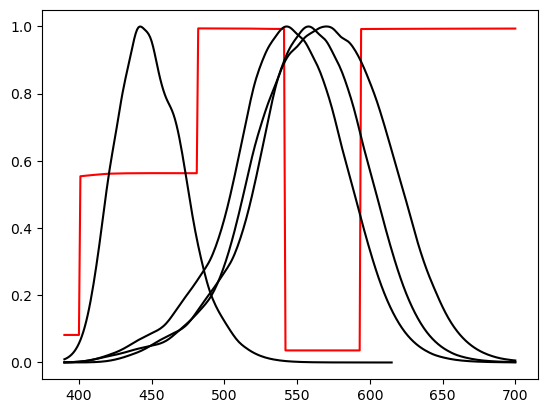

In [170]:
a.plot(color='red')

l_cone.plot(color='black')
q_cone.plot(color='black')
m_cone.plot(color='black')
s_cone.plot(color='black')

### New pigments

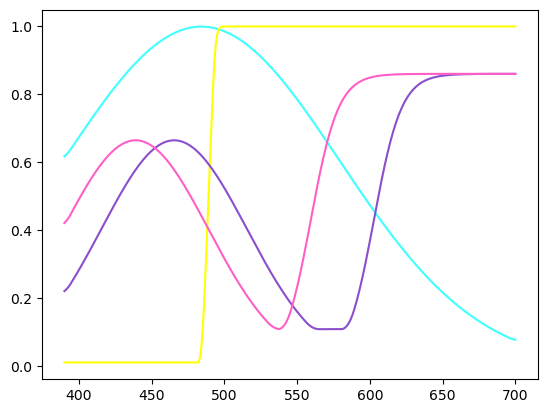

In [31]:
new_pigments = []

fig, ax3 = plt.subplots()
for pigment in np.load("npy/new_pigments.npy"):
    spectra = Spectra(data=np.clip(pigment, 0.01, 1), wavelengths=wavelengths1)
    spectra.plot(ax=ax3)
    new_pigments.append(spectra.interpolate_values(wavelengths10))

In [33]:
new_pigments

In [26]:
new_nb = load_neugebauer(new_pigments, paper)

In [44]:
InkGamut(new_nb).get_width(tetrachromat, stepsize=0.02)

Generating Point Cloud: 100%|██████████████| 6765201/6765201 [01:04<00:00, 104229.12it/s]


Point cloud generated.
maximum distance is 0.04903445950520291 with percentages (0.0, 0.06, 0.96, 0.02) and (0.7000000000000001, 0.02, 0.0, 0.98)


0.04903445950520291

In [48]:
tetrachromat.observe(Spectra( data=new_nb.mix(np.array((0.0, 0.06, 0.96, 0.02))).T, wavelengths=wavelengths10))

array([0.59935068, 0.39594537, 0.3884382 , 0.43626359])

In [50]:
tetrachromat.observe(Spectra( data=new_nb.mix(np.array((0.7, 0.02, 0.0, 0.98))).T, wavelengths=wavelengths10))

array([0.59400094, 0.40491427, 0.4359575 , 0.44299754])

[0.83865184 0.82801044 0.82460456 0.82502493]
[0.68122696 0.50604038 0.57658764 0.62143317]
[0.66907094 0.4011109  0.38954859 0.43764342]
[0.46214945 0.22146146 0.24548809 0.29928098]
[0.08542578 0.91174563 0.94935727 0.95624278]
[0.11544379 0.40646957 0.49625161 0.5464818 ]
[0.1246203  0.29638444 0.31031669 0.36034721]
[0.09219295 0.16285169 0.19789015 0.25141422]
[0.9315123  0.83415551 0.77734516 0.73472882]
[0.58397697 0.36744349 0.38734583 0.38593199]
[0.57389552 0.31641521 0.28483228 0.28901179]
[0.3956903  0.16788204 0.16659445 0.17830197]
[0.16033889 0.70363979 0.66899878 0.63057733]
[0.10297442 0.27999943 0.31314574 0.31378247]
[0.11234861 0.22773969 0.21615676 0.22293001]
[0.0801105  0.11989157 0.12878719 0.14074757]


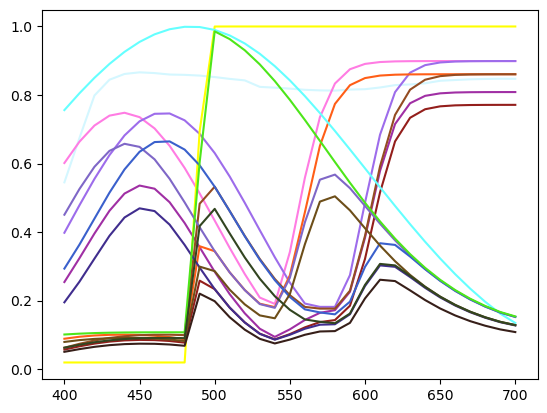

In [39]:
ideal_primaries = []
for s in new_nb.spectras_array:
    spectra = Spectra(data=np.power(s, 50), wavelengths=wavelengths10)
    spectra.plot()
    o = tetrachromat.observe(spectra)
    print(o)
    ideal_primaries.append(o)
np.save("ideal_primaries", ideal_primaries)
plt.show()

In [ ]:
new_pi

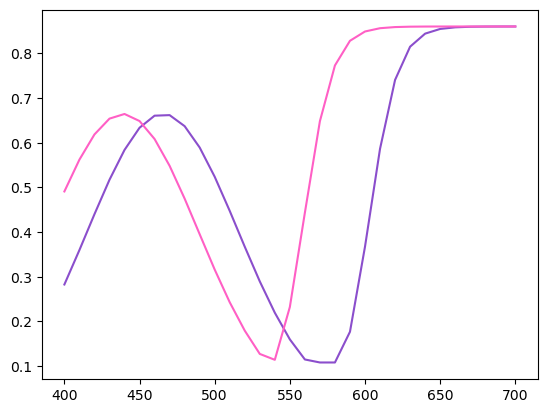

In [26]:
new_pigments[2].plot()
new_pigments[3].plot()
plt.savefig("pink-purple")

In [33]:
gamut_width(new_pigments,
            cmy_primaries_dict["000"],
            tetrachromat_observe10,
            stepsize=0.05)

Generating Point Cloud:   0%|          | 0/194481 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.04417881369590759
with percentages [0.05 0.6  0.95 0.  ] and  [0.7  0.55 0.   1.  ]


0.044178814

In [19]:
fountain_inks.keys()

dict_keys(['Bouquet dantan H', 'Rose cyclamen H', 'Bleu pervenche h', 'Violette pensee h', 'Orange D', 'Peach haze D', 'Hope pink D', 'Atlantic salmon N', 'Operation overlord orange N', 'Dragon catfish N', 'Iroshizuku purple', 'Kaweco green', 'Pilot blue', 'Lamy purple', 'Sailor pink', 'Platinum pink', 'Platinum violet'])

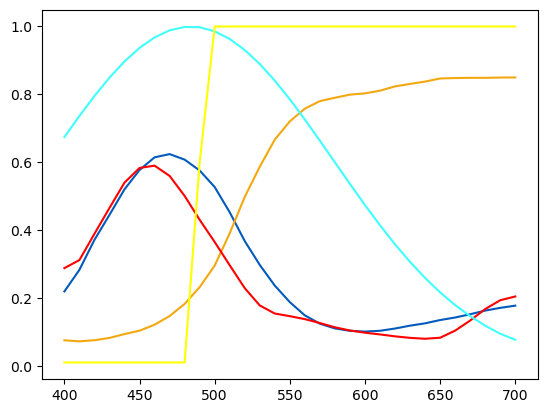

In [20]:
cmy_primaries_dict["100"].plot()
cmy_primaries_dict["001"].plot()
fountain_inks["Pilot blue"].plot(color="red")
new_pigments[0].plot()
new_pigments[1].plot()

In [150]:
gamut_width([cmy_primaries_dict["100"],  
             cmy_primaries_dict["001"],
             new_pigments[2],
             new_pigments[3]
            ],
             paper,
             tetrachromat_observe10,
             save='cyan_yellow_pink_purple',
             stepsize=0.02
)

Generating Point Cloud:   0%|          | 0/6765201 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.03716933727264404
with percentages [0.02 0.06 1.   0.02] and  [0.32 0.   0.   0.86]


0.037169337

## 3.5 Peach Haze vs Pink/Purple

NameError: name 'fountain_inks' is not defined

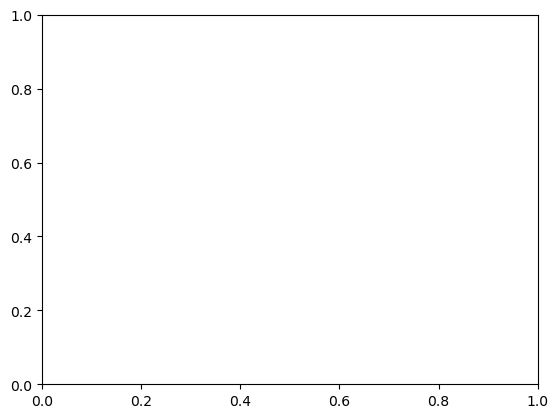

In [7]:
fig, axc = plt.subplots()
fountain_inks['Peach haze D'].plot(ax=axc)
new_pigments[3].plot(ax=axc)
plt.savefig("peachhaze-vs-pink")

In [105]:
fountain_inks.keys()

dict_keys(['Bouquet dantan H', 'Rose cyclamen H', 'Bleu pervenche h', 'Violette pensee h', 'Orange D', 'Peach haze D', 'Hope pink D', 'Atlantic salmon N', 'Operation overlord orange N', 'Dragon catfish N', 'Iroshizuku purple', 'Kaweco green', 'Pilot blue', 'Lamy purple', 'Sailor pink', 'Platinum pink', 'Platinum violet'])

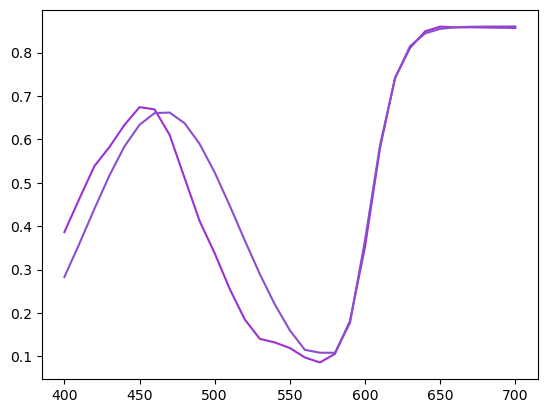

In [109]:
fig, axp = plt.subplots()
fountain_inks['Platinum violet'].plot(ax=axp)
new_pigments[2].plot(ax=axp)

## Best fountain pen inks

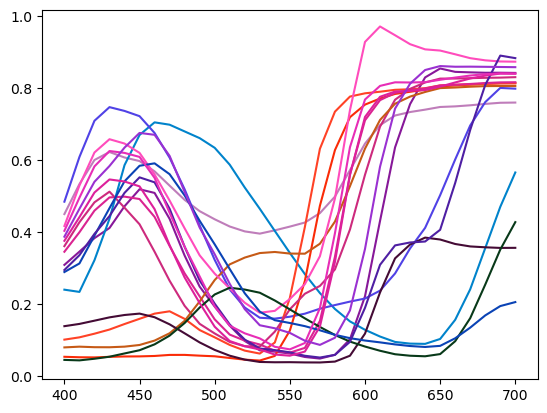

In [18]:
import csv

fountain_inks = {}
fig, axc = plt.subplots()
with open(f'Inks.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i >= 4:
            name = row[4]
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            spectra.plot(ax=axc)
            
            fountain_inks[name] = spectra
            
plt.show()

### Extend CMY with one fountain pen ink

In [39]:
scores = []
for name, spectra in fountain_inks.items():
    inks = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"], spectra]
    score = gamut_width(inks, paper, tetrachromat_observe10)
    scores.append((score, name))

scores.sort()
scores

Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009471029043197632
with percentages [0.8 0.8 0.4 0.6] and  [0.8 0.8 0.5 0.3]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013123080134391785
with percentages [0.3 0.  0.5 0.8] and  [0.4 0.8 0.3 0.2]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010081112384796143
with percentages [1.  0.4 0.9 0.3] and  [0.8 0.4 0.9 0.5]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009291119873523712
with percentages [0.9 0.3 0.2 1. ] and  [0.9 0.4 0.2 0.8]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015383154153823853
with percentages [0.  0.8 0.8 0. ] and  [0.1 0.2 0.  0.7]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017223834991455078
with percentages [0.1 0.6 0.6 0. ] and  [0.2 0.  0.1 0.8]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009876102209091187
with percentages [0. 1. 0. 0.] and  [0.  0.3 0.1 0.6]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011541396379470825
with percentages [0.8 1.  0.1 0. ] and  [0.8 0.2 0.2 0.7]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011081486940383911
with percentages [0.2 0.1 0.  1. ] and  [0.2 0.4 1.  0. ]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01009640097618103
with percentages [0.9 0.5 0.3 0.4] and  [0.9 0.  0.4 0.9]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010145112872123718
with percentages [0.7 0.3 0.  1. ] and  [0.8 0.9 0.1 0.6]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009633801877498627
with percentages [0.8 0.9 0.8 0.9] and  [0.5 0.8 1.  1. ]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010859057307243347
with percentages [0.9 0.2 0.3 0.2] and  [0.3 0.  0.4 0.8]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01072247326374054
with percentages [0.4 0.2 0.9 0.8] and  [0.7 0.9 0.8 0. ]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010165363550186157
with percentages [0.  0.9 1.  0. ] and  [0.  0.7 1.  0.2]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009858399629592896
with percentages [0.8 0.4 0.6 0.1] and  [0.8 0.  0.7 0.4]


Generating Point Cloud:   0%|          | 0/14641 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014239460229873657
with percentages [0.  0.1 0.5 0.9] and  [0.1 0.8 0.3 0.2]


[(0.00929112, 'Violette pensee h'),
 (0.009471029, 'Bouquet dantan H'),
 (0.009633802, 'Kaweco green'),
 (0.0098584, 'Platinum pink'),
 (0.009876102, 'Hope pink D'),
 (0.010081112, 'Bleu pervenche h'),
 (0.010096401, 'Dragon catfish N'),
 (0.010145113, 'Iroshizuku purple'),
 (0.010165364, 'Sailor pink'),
 (0.010722473, 'Lamy purple'),
 (0.010859057, 'Pilot blue'),
 (0.011081487, 'Operation overlord orange N'),
 (0.011541396, 'Atlantic salmon N'),
 (0.01312308, 'Rose cyclamen H'),
 (0.01423946, 'Platinum violet'),
 (0.015383154, 'Orange D'),
 (0.017223835, 'Peach haze D')]

### Extend CMY with 3 fountain pen inks

In [44]:
from itertools import combinations

scores = []
ink_names = list(fountain_inks.keys())  # Extract the ink names
total_combinations = len(list(combinations(ink_names, 3)))  # Calculate total combinations

# Iterate over combinations of the ink names
for combo_names in tqdm(combinations(ink_names, 3), total=total_combinations, desc="Processing combinations"):
    inks = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"]]
    # Add the spectra for each ink in the combination
    inks.extend([fountain_inks[name] for name in combo_names])
    score = gamut_width(inks, paper, tetrachromat_observe10, stepsize=0.25)
    scores.append((score, combo_names))

# Sort the scores
scores.sort(reverse=True)  # Assuming you want the highest score first

# The best combination of inks
best_combo = scores[0]

Processing combinations:   0%|          | 0/680 [00:00<?, ?it/s]

Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010797038674354553
with percentages [0.25 1.   0.75 0.   0.75 0.5 ] and  [0.25 1.   0.75 1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013117164373397827
with percentages [0.   0.   0.5  0.   0.75 0.25] and  [0.25 1.   0.25 0.25 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018448859453201294
with percentages [0.   0.25 1.   0.   0.5  0.25] and  [0.25 0.   0.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.019856125116348267
with percentages [0.   0.   0.75 0.25 0.75 0.  ] and  [0.25 0.   0.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014054521918296814
with percentages [0.   0.25 0.   0.75 0.75 0.  ] and  [0.25 0.5  0.   0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015219613909721375
with percentages [0.   0.   0.25 0.5  1.   0.  ] and  [0.25 0.5  0.   0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012479618191719055
with percentages [0.   0.   0.75 0.   1.   0.5 ] and  [0.   0.75 0.5  1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013732686638832092
with percentages [0.   0.25 1.   0.75 0.75 0.  ] and  [0.25 0.5  1.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012341693043708801
with percentages [0.25 0.   0.25 0.   0.25 0.75] and  [0.5  1.   0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01137535274028778
with percentages [0.25 0.   1.   0.   0.75 0.  ] and  [0.   0.25 0.75 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011328309774398804
with percentages [0.   0.5  0.25 0.   1.   0.25] and  [0.25 1.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012268289923667908
with percentages [0.   0.   0.5  0.5  1.   0.25] and  [0.   1.   0.25 0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015313893556594849
with percentages [0.   0.   0.75 0.75 0.75 0.  ] and  [0.25 0.   0.75 0.5  0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01649509370326996
with percentages [0.   0.   0.   0.25 1.   0.  ] and  [0.25 0.   0.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012782439589500427
with percentages [0.   0.25 0.25 0.   0.75 0.25] and  [0.   0.75 0.   0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009932570159435272
with percentages [1.   0.   1.   0.25 0.25 0.5 ] and  [0.75 0.   1.   0.25 0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.   0.25 0.  ] and  [0.25 0.   0.   0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016240298748016357
with percentages [0.   0.5  1.   0.75 0.   0.  ] and  [0.   0.   0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00985889881849289
with percentages [1.   1.   0.5  0.   0.   0.25] and  [0.25 1.   0.5  0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011042192578315735
with percentages [0.75 0.5  1.   0.25 0.   0.5 ] and  [0.   0.   1.   0.25 0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010759979486465454
with percentages [1.   0.25 0.   0.25 0.   1.  ] and  [0.25 0.25 0.75 1.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01088288426399231
with percentages [0.5  0.5  0.   0.25 0.   0.75] and  [0.   0.25 0.   0.5  0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010573968291282654
with percentages [0.25 0.   0.25 0.   0.   0.75] and  [0.5  0.75 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010211050510406494
with percentages [1.   0.   1.   0.   0.5  0.25] and  [0.   0.   0.25 0.5  0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010552942752838135
with percentages [0.75 0.   0.5  1.   0.   0.25] and  [0.   0.25 0.5  0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01043923944234848
with percentages [0.75 0.25 0.5  0.   0.25 1.  ] and  [0.   0.75 0.25 0.75 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010315179824829102
with percentages [1.   0.   1.   0.5  0.25 0.5 ] and  [0.25 0.   1.   0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01046060025691986
with percentages [0.25 0.75 0.5  1.   0.5  0.25] and  [0.   0.   0.75 0.5  0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0109853595495224
with percentages [0.   0.25 0.5  0.   0.25 1.  ] and  [0.25 0.75 0.25 0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603957533836365
with percentages [0.   0.25 1.   0.   0.75 0.25] and  [0.5 0.  0.5 0.  0.  1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010671593248844147
with percentages [0.  0.5 1.  0.  1.  1. ] and  [0.25 0.25 1.   0.75 0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010962612926959991
with percentages [0.   1.   0.25 1.   1.   0.  ] and  [0.5  0.25 0.25 0.75 0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010471060872077942
with percentages [0.   0.75 0.   0.   0.75 1.  ] and  [0.25 1.   0.75 0.25 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010555744171142578
with percentages [0.   0.75 0.   0.75 1.   0.  ] and  [0.5  0.5  0.   0.25 0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010573968291282654
with percentages [0.25 0.   0.25 0.   0.   0.75] and  [0.5  0.75 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010045208036899567
with percentages [0.25 0.75 1.   0.25 0.75 0.25] and  [0.5  0.75 1.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010030306875705719
with percentages [0.75 0.5  1.   0.   1.   0.5 ] and  [0.5  0.75 1.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01184418797492981
with percentages [0.   0.   0.25 0.25 0.75 0.75] and  [0.25 0.5  0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010357856750488281
with percentages [0.   0.75 0.75 0.   0.5  0.75] and  [0.25 0.5  0.75 0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010452896356582642
with percentages [0.   1.   0.5  0.25 0.75 0.25] and  [0.25 0.5  0.5  0.75 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011584952473640442
with percentages [0.25 0.   1.   0.75 0.5  1.  ] and  [0.5  1.   0.75 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016394346952438354
with percentages [0.   1.   1.   0.   0.25 0.25] and  [0.   0.   0.25 1.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015516668558120728
with percentages [0.   0.5  0.25 0.25 0.25 1.  ] and  [0.25 0.   0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01628457009792328
with percentages [0.   0.5  1.   0.75 0.   0.75] and  [0.25 0.   0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016289323568344116
with percentages [0.   0.75 1.   0.25 0.25 0.  ] and  [0.   0.   0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015070691704750061
with percentages [0.   0.75 1.   1.   0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016462981700897217
with percentages [0.   0.5  1.   0.5  0.   0.25] and  [0.25 0.   0.25 0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013476505875587463
with percentages [0.25 0.   0.75 0.5  0.   0.75] and  [0.25 0.   0.   1.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013313308358192444
with percentages [0.25 0.5  1.   1.   0.   0.  ] and  [0.5 0.  0.5 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016867905855178833
with percentages [0.   0.5  0.25 1.   0.25 0.25] and  [0.25 0.25 0.   0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01661062240600586
with percentages [0.   0.75 0.5  0.   0.   0.25] and  [0.   0.   0.   0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013889625668525696
with percentages [0.   1.   1.   0.25 0.   0.25] and  [0.25 0.5  0.5  0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014082938432693481
with percentages [0.25 0.5  1.   0.   0.25 0.25] and  [0.   0.   0.5  0.25 0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013429805636405945
with percentages [0.75 0.75 0.75 0.   0.25 0.  ] and  [0.   0.   0.5  0.5  0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014069870114326477
with percentages [0.   0.75 0.75 1.   0.   0.25] and  [0.25 0.   0.25 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014678001403808594
with percentages [0.   0.75 0.75 1.   0.   0.5 ] and  [0.25 0.   0.25 0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.020988374948501587
with percentages [0.   0.   1.   0.5  0.   0.75] and  [0.25 0.   0.25 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010517239570617676
with percentages [0.   0.25 0.   0.   0.25 0.25] and  [0.   0.   0.   0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010283783078193665
with percentages [0.   1.   0.5  0.25 0.5  1.  ] and  [0.   0.5  1.   0.5  0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010939523577690125
with percentages [0.   1.   1.   0.   0.25 0.25] and  [0.   0.25 1.   0.5  0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011243939399719238
with percentages [0.   0.25 0.5  0.5  0.   1.  ] and  [0.5  1.   0.75 0.25 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009858254343271255
with percentages [1.   0.75 0.   0.   0.75 1.  ] and  [1.   0.5  0.5  0.75 0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01099790632724762
with percentages [0.75 1.   0.5  1.   0.5  0.  ] and  [0.   0.   0.75 1.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012553617358207703
with percentages [0.   0.   0.25 0.25 0.25 1.  ] and  [0.5  0.5  0.   0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009194381535053253
with percentages [0.5  0.75 1.   0.25 0.5  1.  ] and  [0.5  0.75 1.   0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010364025831222534
with percentages [0.75 1.   0.5  1.   0.5  0.  ] and  [0.75 0.25 0.75 1.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014010831713676453
with percentages [0.   0.25 0.5  1.   0.   0.75] and  [0.25 0.25 0.5  0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011801168322563171
with percentages [0.25 1.   0.   0.5  0.   0.75] and  [0.25 0.   0.75 0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010358273983001709
with percentages [0.25 0.25 0.25 0.25 0.25 0.5 ] and  [0.25 0.   0.25 0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011439457535743713
with percentages [0.  0.  0.5 0.  0.  1. ] and  [0.5  0.25 0.75 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01027592271566391
with percentages [0.75 0.75 1.   0.75 0.25 0.  ] and  [0.   0.   0.5  0.5  1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010416984558105469
with percentages [1.   1.   0.   0.25 0.   0.  ] and  [0.   0.   0.25 0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011975809931755066
with percentages [0.   0.25 0.5  0.25 0.   1.  ] and  [0.5  0.25 0.25 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010232359170913696
with percentages [1.   0.25 0.25 0.5  0.   1.  ] and  [1.   0.   0.25 0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009970709681510925
with percentages [0.75 1.   0.5  1.   0.5  0.  ] and  [0.75 0.25 0.75 1.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01280994713306427
with percentages [0.   0.5  1.   0.25 0.5  1.  ] and  [0.   0.75 0.75 1.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011256054043769836
with percentages [0.   1.   0.75 0.5  0.75 0.25] and  [0.   0.25 1.   1.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010683082044124603
with percentages [0.5 0.  0.5 0.  0.5 1. ] and  [0.75 1.   1.   0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011238008737564087
with percentages [0.5  0.   0.25 0.5  0.75 0.  ] and  [0.25 0.   0.75 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011134028434753418
with percentages [0.75 0.25 0.25 0.   0.5  0.  ] and  [0.25 0.   0.5  0.5  0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011191099882125854
with percentages [0.25 0.   0.25 0.25 0.5  0.75] and  [0.5  0.75 0.5  0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011612892150878906
with percentages [0.   0.25 0.   0.5  1.   0.  ] and  [0.   0.   1.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010962262749671936
with percentages [0.25 0.75 0.25 0.5  1.   0.75] and  [0.25 0.25 1.   0.75 0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013359278440475464
with percentages [0.   0.25 0.75 0.   1.   0.5 ] and  [0.   0.5  0.75 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011524379253387451
with percentages [0.   0.25 0.5  0.5  0.   1.  ] and  [0.5  1.   0.75 0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010637432336807251
with percentages [0.5  0.75 1.   0.25 0.   0.25] and  [0.   0.   0.75 0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010083720088005066
with percentages [1.   0.25 0.25 1.   0.   0.  ] and  [0.  0.  0.5 0.  0.5 1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011970698833465576
with percentages [0.   0.75 0.25 0.75 0.25 0.5 ] and  [0.25 0.75 0.25 0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010708659887313843
with percentages [0.25 0.75 0.25 0.   0.5  0.25] and  [0.25 0.5  0.25 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009983628988265991
with percentages [0.25 0.25 0.5  0.25 0.   0.25] and  [0.25 0.   0.5  0.5  0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017802178859710693
with percentages [0.   0.   0.25 0.25 0.   1.  ] and  [0.25 0.5  0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010793425142765045
with percentages [0.5  0.25 0.25 0.75 0.75 0.25] and  [0.25 1.   0.   0.75 0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010908737778663635
with percentages [0.25 0.   0.25 0.   0.75 0.  ] and  [0.25 0.75 0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010574012994766235
with percentages [0.25 0.   0.25 0.   0.75 0.  ] and  [0.5  0.75 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01158478856086731
with percentages [0.25 0.25 0.   0.25 0.75 0.  ] and  [0.5  0.   0.25 0.25 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011313974857330322
with percentages [0.  0.  0.  0.5 1.  0. ] and  [0.5  1.   0.25 0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011733844876289368
with percentages [0.   0.25 0.25 0.   0.75 0.25] and  [0.25 1.   0.25 0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010059654712677002
with percentages [0.5  1.   0.   0.25 1.   0.  ] and  [0.25 0.75 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010572999715805054
with percentages [0.   0.5  0.25 0.5  0.25 0.75] and  [0.5  1.   0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01040666550397873
with percentages [0.75 0.   1.   0.5  0.5  1.  ] and  [0.   0.   0.75 1.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0112074613571167
with percentages [0.25 0.25 0.5  0.25 0.25 1.  ] and  [0.25 0.75 0.25 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010987244546413422
with percentages [1.   0.   1.   0.25 0.   1.  ] and  [0.25 0.25 1.   0.75 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010083388537168503
with percentages [0.5  1.   0.   0.25 0.75 1.  ] and  [0.   0.5  0.25 0.75 1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010393328964710236
with percentages [0.75 1.   0.5  0.   0.25 0.  ] and  [0.25 0.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01185646653175354
with percentages [0.25 0.25 0.5  0.25 0.   1.  ] and  [0.   0.75 0.25 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011332198977470398
with percentages [0.25 0.25 0.75 0.   0.5  0.25] and  [0.5  0.   0.75 0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011309266090393066
with percentages [0.  1.  0.  0.  0.5 0.5] and  [0.25 0.75 0.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012082859873771667
with percentages [0.25 0.   0.5  0.   0.5  0.75] and  [0.25 0.5  0.25 0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009927898645401001
with percentages [0.75 0.5  0.   0.75 0.75 0.25] and  [0.75 0.   0.25 0.75 0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015375897288322449
with percentages [0.  0.  0.5 1.  0.  1. ] and  [0.25 0.   0.5  0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01741895079612732
with percentages [0.   0.25 0.   0.25 0.   1.  ] and  [0.25 0.   0.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841835618019104
with percentages [0.25 0.   0.25 0.75 0.   0.75] and  [0.5 1.  0.  0.  0.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016810983419418335
with percentages [0.   0.5  1.   0.25 0.   0.  ] and  [0.   0.   0.25 0.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018973544239997864
with percentages [0.25 0.   1.   0.75 0.   0.  ] and  [0.25 0.25 0.25 0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013122320175170898
with percentages [0.25 0.   0.25 1.   0.   0.25] and  [0.25 0.5  0.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012761279940605164
with percentages [0.5  0.   0.25 0.75 0.   0.  ] and  [0.25 0.5  0.   0.   0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011617988348007202
with percentages [0.25 0.   0.25 0.75 0.   0.25] and  [0.   1.   0.25 0.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011452525854110718
with percentages [0.5  0.25 0.25 0.75 0.5  0.  ] and  [1.   0.25 0.25 0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011243551969528198
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   1.   0.5  0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010326355695724487
with percentages [0.5  0.5  0.75 0.5  0.25 0.25] and  [0.   1.   0.25 0.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010522983968257904
with percentages [0.25 0.5  1.   0.5  0.5  0.25] and  [0.25 1.   1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010591335594654083
with percentages [0.5 0.  0.5 0.  0.  1. ] and  [0.   0.75 0.25 0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013282537460327148
with percentages [0.   0.   0.25 1.   0.   0.5 ] and  [0.   0.75 0.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011515408754348755
with percentages [0.   1.   1.   1.   0.25 0.  ] and  [0.25 1.   1.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012942969799041748
with percentages [0.   0.   0.25 0.5  0.25 0.5 ] and  [0.  1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014436498284339905
with percentages [0.25 0.25 1.   0.75 0.   0.  ] and  [0.5  0.   0.25 0.25 0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01705092191696167
with percentages [0.25 0.   1.   1.   0.25 0.  ] and  [0.5  0.5  0.25 0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013490870594978333
with percentages [0.   0.   0.25 1.   0.25 0.5 ] and  [0.   0.75 0.   0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013621151447296143
with percentages [0.   0.   0.25 0.75 0.   0.  ] and  [0.   0.75 0.   0.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013159587979316711
with percentages [0.  0.  1.  1.  0.5 0. ] and  [0.   0.   1.   0.25 0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013470768928527832
with percentages [0.   0.5  0.   0.75 0.5  0.  ] and  [0.5  0.25 0.   0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013469427824020386
with percentages [0.  0.  0.  1.  0.  0.5] and  [0.   0.   0.   0.5  0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012841582298278809
with percentages [0.25 0.   0.25 0.75 0.75 0.  ] and  [0.5 1.  0.  0.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.019365280866622925
with percentages [0.   0.25 1.   0.5  0.5  0.  ] and  [0.25 0.   0.   0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016277045011520386
with percentages [0.   1.   1.   0.75 0.   0.5 ] and  [0.25 0.5  0.   0.   1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016008242964744568
with percentages [0.   0.   1.   0.75 0.5  0.  ] and  [0.25 0.   0.25 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01925903558731079
with percentages [0.   0.25 1.   0.25 0.   1.  ] and  [0.25 0.   0.75 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015767306089401245
with percentages [0.   0.   0.75 0.75 0.   0.  ] and  [0.25 0.   0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014436736702919006
with percentages [0.25 0.5  1.   1.   0.5  0.  ] and  [0.25 0.   0.   0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01524960994720459
with percentages [0.   0.25 1.   1.   0.25 0.25] and  [0.   1.   0.   0.   0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014797404408454895
with percentages [0.25 0.5  0.75 0.75 0.   0.  ] and  [0.25 0.25 0.   0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015487641096115112
with percentages [0.   0.25 1.   0.5  0.   0.25] and  [0.25 0.   0.25 0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017302870750427246
with percentages [0.  0.  1.  1.  0.  0.5] and  [0.25 0.25 0.5  0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01843942701816559
with percentages [0.   0.5  0.5  0.75 0.25 0.  ] and  [0.25 0.   0.   0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016617119312286377
with percentages [0.   0.   1.   0.5  0.   0.75] and  [0.25 0.75 0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01727837324142456
with percentages [0.25 0.   1.   1.   0.   0.25] and  [0.5  0.   0.25 0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016897931694984436
with percentages [0.   0.   0.75 0.75 0.25 0.  ] and  [0.25 0.   0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018944233655929565
with percentages [0.  0.  1.  0.5 0.  1. ] and  [0.25 0.   0.75 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.020404785871505737
with percentages [0.   0.25 0.75 0.5  0.   0.25] and  [0.25 0.25 0.   0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014754638075828552
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   0.   0.   0.25 0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018223777413368225
with percentages [0.25 0.   1.   1.   0.   0.  ] and  [0.25 0.25 0.   0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018608197569847107
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   1.   0.   0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01787620782852173
with percentages [0. 0. 1. 1. 0. 0.] and  [0.25 0.25 0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017355889081954956
with percentages [0.   0.5  0.75 1.   0.   0.  ] and  [0.25 0.   0.25 0.25 0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.021462425589561462
with percentages [0.   0.   1.   0.75 0.   0.25] and  [0.25 0.   0.25 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01817944645881653
with percentages [0.25 0.   1.   1.   0.   0.  ] and  [0.5  0.25 0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012854114174842834
with percentages [0.   0.   0.25 1.   0.5  0.  ] and  [0.25 0.25 0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01409594714641571
with percentages [0.   0.25 0.25 1.   0.25 0.5 ] and  [0.25 0.75 0.5  0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014472812414169312
with percentages [0.   0.   0.25 1.   0.   0.5 ] and  [0.25 0.5  0.   0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01329679787158966
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   0.75 0.5  0.25 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012722879648208618
with percentages [0.   0.5  0.5  1.   0.   0.25] and  [0.   0.5  0.25 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010887712240219116
with percentages [0.   0.   0.25 1.   0.25 0.  ] and  [0.   0.5  0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011457070708274841
with percentages [0.  0.  1.  0.5 0.5 1. ] and  [0.5  1.   0.75 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017099007964134216
with percentages [0.   0.25 0.75 1.   0.25 0.  ] and  [0.25 0.   0.75 0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014615267515182495
with percentages [0.   0.25 0.   0.75 0.5  0.  ] and  [0.25 0.   0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016461625695228577
with percentages [0.   0.   0.25 0.75 0.   1.  ] and  [0.25 0.5  0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01316244900226593
with percentages [0.   0.   0.75 1.   0.   0.75] and  [0.25 0.75 1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013924568891525269
with percentages [0.  0.  0.5 1.  0.  0.5] and  [0.25 0.25 0.25 0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014620065689086914
with percentages [0.   0.   0.75 0.75 0.   0.  ] and  [0.   0.25 0.5  0.   0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012514710426330566
with percentages [0.5  0.25 1.   0.75 0.   0.5 ] and  [0.  0.  0.5 0.  1.  1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012020394206047058
with percentages [1.   0.   0.75 1.   0.   0.25] and  [0.5  0.   0.75 0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015697568655014038
with percentages [0.   0.   0.5  0.75 0.   0.25] and  [0.25 0.25 0.25 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015302225947380066
with percentages [0.   0.   0.25 1.   0.   0.5 ] and  [0.25 0.25 0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012027084827423096
with percentages [0.   0.75 0.75 1.   0.25 0.25] and  [0.25 0.25 0.75 0.   1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014726951718330383
with percentages [0.   0.   0.25 0.75 0.   1.  ] and  [0.25 0.25 0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012073636054992676
with percentages [0.   0.25 0.5  1.   1.   0.  ] and  [0.25 1.   0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012444272637367249
with percentages [0. 0. 0. 1. 1. 0.] and  [0.   1.   0.75 0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010849468410015106
with percentages [0.5  0.25 0.25 1.   1.   0.25] and  [0.   1.   0.75 0.5  0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011472873389720917
with percentages [0.5  0.25 0.   0.75 1.   0.5 ] and  [0.   1.   0.75 0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011367909610271454
with percentages [0.   0.   0.75 1.   1.   0.5 ] and  [0.   1.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015485316514968872
with percentages [0.   0.25 0.25 0.75 1.   0.  ] and  [0.25 0.   1.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013543084263801575
with percentages [0.   0.   1.   1.   0.25 0.  ] and  [0.25 0.   0.5  0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01179802417755127
with percentages [0.   0.   0.25 0.5  0.   0.5 ] and  [0.25 1.   0.   0.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012866154313087463
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   0.25 0.5  0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01121407002210617
with percentages [0.   0.   0.25 1.   0.25 0.5 ] and  [0.25 0.75 0.   0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011197447776794434
with percentages [0.   0.25 0.   0.5  0.   0.25] and  [0.  0.  0.  0.  1.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013363882899284363
with percentages [0.   0.   0.25 0.75 0.5  0.25] and  [0.   0.   0.25 0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015723630785942078
with percentages [0.25 0.25 0.25 1.   0.5  0.  ] and  [0.5  0.   0.25 0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01588226854801178
with percentages [0.   0.5  0.   0.75 0.   0.  ] and  [0.25 0.   0.   0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013904169201850891
with percentages [0.   0.   0.75 0.75 0.25 1.  ] and  [0.25 1.   0.5  0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011243477463722229
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   1.   0.5  0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012681841850280762
with percentages [0.25 0.   0.   0.5  0.75 0.  ] and  [0.   1.   0.   0.25 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011243477463722229
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   1.   0.5  0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013616666197776794
with percentages [0.   0.   0.25 1.   0.25 0.  ] and  [0.25 1.   0.   0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013194680213928223
with percentages [0.   0.75 0.   0.75 0.25 0.  ] and  [0.25 1.   0.   0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0129566490650177
with percentages [0.   0.   1.   0.5  0.   0.75] and  [0.   0.75 0.75 0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010786652565002441
with percentages [1.   0.5  0.75 1.   1.   0.  ] and  [0. 1. 1. 0. 1. 1.]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011086344718933105
with percentages [0.   0.25 0.75 1.   0.25 0.  ] and  [0.25 1.   0.75 0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012823611497879028
with percentages [0.   0.25 0.5  0.75 0.25 0.25] and  [0.5  0.   0.75 0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012107357382774353
with percentages [0.   0.25 0.75 1.   0.   0.  ] and  [0.   0.5  0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01179802417755127
with percentages [0.   0.   0.25 0.5  0.   0.5 ] and  [0.25 1.   0.   0.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011043988168239594
with percentages [0.75 0.   1.   1.   0.   1.  ] and  [0.5  1.   1.   0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012189969420433044
with percentages [0.   0.25 1.   1.   0.   0.  ] and  [0.   0.25 1.   0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014882251620292664
with percentages [0.25 0.   1.   1.   0.   0.  ] and  [0.  0.  1.  0.  0.5 1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01179802417755127
with percentages [0.   0.   0.25 0.5  0.   0.5 ] and  [0.25 1.   0.   0.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013243436813354492
with percentages [0.   0.   0.25 0.75 0.25 0.  ] and  [0.25 0.75 0.   0.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016183972358703613
with percentages [0.   0.   0.25 1.   0.   0.25] and  [0.   0.   0.25 0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01179802417755127
with percentages [0.   0.   0.25 0.5  0.   0.5 ] and  [0.25 1.   0.   0.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015027061104774475
with percentages [0.   0.   0.5  0.75 0.   0.5 ] and  [0.25 0.   0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015666373074054718
with percentages [0.   0.25 0.25 1.   0.   1.  ] and  [0.25 1.   0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015539303421974182
with percentages [0.25 0.   0.25 0.75 0.   0.25] and  [0.5  0.   0.25 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603957533836365
with percentages [0.   0.25 1.   0.   0.75 0.25] and  [0.5 0.  0.5 0.  0.  1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01018255203962326
with percentages [0.   0.5  0.75 0.75 1.   0.75] and  [0.   0.5  0.75 1.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011051222681999207
with percentages [0. 0. 1. 0. 1. 0.] and  [0.   0.   0.75 0.5  0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010654032230377197
with percentages [0.25 0.   0.   0.25 0.75 0.5 ] and  [0.   0.75 0.25 0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01015559583902359
with percentages [0.5  0.25 0.75 0.5  1.   0.25] and  [0.75 0.25 0.75 0.5  0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0100039541721344
with percentages [0.5  0.   0.   0.5  0.25 1.  ] and  [0.75 0.5  0.25 0.25 0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0100630521774292
with percentages [0.75 0.5  0.   0.   0.5  0.75] and  [0.5  0.75 0.25 0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010097384452819824
with percentages [0.5  0.75 0.   0.   0.   0.  ] and  [0.   0.75 0.   0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010952994227409363
with percentages [0.75 0.   0.5  0.   0.25 1.  ] and  [0.   1.   0.25 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010460391640663147
with percentages [1.  0.5 1.  0.  0.5 0. ] and  [0.25 0.   1.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010199666023254395
with percentages [0.75 0.75 1.   0.   1.   0.25] and  [0.25 0.5  1.   0.75 0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011592403054237366
with percentages [0.   0.   0.75 0.25 0.5  1.  ] and  [0.5  1.   0.5  0.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016352161765098572
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012361794710159302
with percentages [0.5  0.75 0.5  0.5  0.25 0.  ] and  [0.   0.   0.   1.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01251944899559021
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.   0.   0.75 0.5  0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012807711958885193
with percentages [0.25 0.5  0.75 0.   0.   1.  ] and  [0.25 0.   1.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011563718318939209
with percentages [0.5  0.5  0.5  0.5  0.25 0.25] and  [0.   0.   0.   1.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015773743391036987
with percentages [0.25 0.25 0.5  0.   0.   0.5 ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013044491410255432
with percentages [0.25 0.5  0.25 0.5  0.   0.25] and  [0.   0.   0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012430787086486816
with percentages [1.  0.5 0.  0.  0.5 0. ] and  [0.   0.   0.   0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011629506945610046
with percentages [0.5  0.75 1.   0.25 0.   1.  ] and  [0.   0.   0.5  0.75 1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012028008699417114
with percentages [0.5  0.75 0.5  0.25 0.25 0.75] and  [0.   0.5  0.   0.75 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018602654337882996
with percentages [0.25 0.   0.75 0.   0.   1.  ] and  [0.25 0.5  0.   0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011632859706878662
with percentages [0.   0.25 0.   0.25 0.25 0.  ] and  [0.   0.   0.   0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011081099510192871
with percentages [1.   0.75 0.   0.   0.25 1.  ] and  [0.   0.25 0.5  1.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01049068570137024
with percentages [0.75 0.   0.   0.25 0.5  0.25] and  [0.25 0.   0.   0.75 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010549444705247879
with percentages [0.5  0.5  0.25 0.   0.5  1.  ] and  [0.25 0.5  0.5  0.5  1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009873215109109879
with percentages [1.   0.75 0.75 0.   0.5  1.  ] and  [0.5  0.   1.   0.75 1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010401442646980286
with percentages [0.75 0.   0.75 0.   0.75 0.25] and  [0.   0.   0.75 0.5  0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01171083003282547
with percentages [0.   1.   0.75 0.25 0.   1.  ] and  [0.25 0.75 0.75 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010019518435001373
with percentages [0.5  0.75 0.25 0.5  0.75 1.  ] and  [0.25 0.   0.5  0.75 1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009985744953155518
with percentages [0.5  1.   0.5  0.   0.   0.25] and  [0.   1.   0.5  0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01180964708328247
with percentages [1.   0.   0.25 0.   0.   1.  ] and  [0.25 0.25 0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01290789246559143
with percentages [0.5  0.75 0.25 0.   0.   0.25] and  [0.   0.   0.   0.5  0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010998591780662537
with percentages [0.5  0.75 0.25 0.   0.   0.25] and  [0.   0.25 0.25 0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011616580188274384
with percentages [0.25 0.75 0.25 0.25 0.   1.  ] and  [0.   1.   0.5  0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010870859026908875
with percentages [0.75 0.5  0.5  0.   0.25 0.5 ] and  [0.   0.   0.25 0.5  0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011008426547050476
with percentages [0.5  0.5  0.25 0.   0.5  0.25] and  [0.   0.   0.25 0.5  1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012921690940856934
with percentages [0.  0.  0.5 0.5 0.  1. ] and  [0.25 0.   0.25 0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010976985096931458
with percentages [0.25 0.75 0.75 0.   0.   0.5 ] and  [0.   0.25 0.75 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011713981628417969
with percentages [0.25 1.   1.   0.   0.   0.25] and  [0.   0.   1.   0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012127429246902466
with percentages [0.5  1.   0.25 0.25 0.   0.25] and  [0.   0.25 0.25 0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011052832007408142
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.   0.   0.5  0.5  0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010090433061122894
with percentages [0.25 0.   0.   0.25 0.75 0.75] and  [0.   1.   0.5  0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011836513876914978
with percentages [0.25 0.   0.   0.   0.75 0.5 ] and  [0.   0.25 0.75 0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01029050350189209
with percentages [0.75 0.   0.   0.   0.25 0.25] and  [0.25 0.   0.   0.25 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01093168556690216
with percentages [0.5  0.   0.5  0.25 0.75 0.75] and  [0.25 1.   1.   0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010444015264511108
with percentages [0.5  0.75 0.75 0.   1.   0.75] and  [0.   0.25 1.   0.5  1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010604530572891235
with percentages [0.25 1.   0.   0.25 0.75 0.  ] and  [0.   0.25 0.5  0.5  0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011055782437324524
with percentages [0.75 0.   0.   0.   0.75 1.  ] and  [0.25 1.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011447668075561523
with percentages [0.75 0.25 0.25 0.25 0.   0.75] and  [0.25 0.5  0.5  1.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010370157659053802
with percentages [0.5  0.5  0.   0.25 0.25 1.  ] and  [0.   0.25 0.5  1.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010097384452819824
with percentages [0.5  0.75 0.   0.   0.   0.  ] and  [0.   0.75 0.   0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011683836579322815
with percentages [0.   0.5  1.   0.25 0.   0.5 ] and  [0.5  0.25 1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010420113801956177
with percentages [0.5  0.25 0.75 0.25 0.   0.25] and  [0.   0.   0.75 0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010116353631019592
with percentages [1.   1.   0.25 0.5  0.   0.5 ] and  [0.75 0.   0.5  0.75 0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011872082948684692
with percentages [0.   0.25 0.75 0.5  0.   0.75] and  [0.25 0.   0.75 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011004313826560974
with percentages [0.25 0.   0.25 0.75 1.   0.  ] and  [0.   1.   0.25 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010531723499298096
with percentages [1.   0.   0.25 0.   1.   0.  ] and  [0.25 0.75 0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00991741567850113
with percentages [1.   0.   0.5  0.25 1.   0.  ] and  [0.75 1.   0.75 0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01100081205368042
with percentages [0.   0.   0.   0.25 0.5  0.25] and  [0.  1.  0.  0.5 0.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01145121455192566
with percentages [0.   0.   0.   0.25 1.   0.25] and  [0.25 0.75 0.25 0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0116187185049057
with percentages [0.25 0.   0.5  0.25 0.25 1.  ] and  [0.5  0.5  0.25 0.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010454371571540833
with percentages [0.75 0.   1.   1.   0.   0.5 ] and  [0.   0.   0.25 0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010486260056495667
with percentages [0.25 0.   1.   0.25 0.75 0.75] and  [0.   0.5  0.75 0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010034248232841492
with percentages [1.   0.   1.   0.5  0.5  0.25] and  [0.   0.25 0.75 1.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010420829057693481
with percentages [0.75 0.75 0.   0.   0.5  0.5 ] and  [0.   1.   0.   0.75 0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010485559701919556
with percentages [0.75 0.   1.   0.   0.   0.5 ] and  [0.25 0.25 1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010097473859786987
with percentages [0.5  0.75 0.   0.   0.   0.  ] and  [0.   0.75 0.   0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010393328964710236
with percentages [0.75 1.   0.5  0.   0.25 0.  ] and  [0.25 0.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011107593774795532
with percentages [0.5  0.   1.   0.25 0.   0.25] and  [0.   0.   1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011332198977470398
with percentages [0.25 0.25 0.75 0.   0.5  0.25] and  [0.5  0.   0.75 0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012023136019706726
with percentages [0.   0.25 1.   0.25 1.   0.5 ] and  [0.5  0.5  1.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010204106569290161
with percentages [0.5  0.   0.25 0.   0.5  0.75] and  [0.25 0.75 0.   0.5  0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010242506861686707
with percentages [1.   0.   0.   0.   0.75 1.  ] and  [0.   0.   0.   1.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01302318274974823
with percentages [0.25 0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013232722878456116
with percentages [0.   0.25 0.   0.25 0.   1.  ] and  [0.25 0.   0.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603957533836365
with percentages [0.   0.25 1.   0.75 0.   0.25] and  [0.5 0.  0.5 0.  0.  1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013068720698356628
with percentages [0.   0.5  1.   0.25 0.5  0.5 ] and  [0.25 0.   0.5  0.   1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012837707996368408
with percentages [0.   0.25 1.   0.25 0.5  0.5 ] and  [0.25 0.25 0.5  0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016035273671150208
with percentages [0.   0.75 0.5  0.25 0.   0.75] and  [0.25 0.   0.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015285179018974304
with percentages [0.   1.   1.   0.   0.   0.75] and  [0.   0.25 0.   0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013502925634384155
with percentages [0.   1.   1.   0.25 0.   0.5 ] and  [0.5  0.25 0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824520468711853
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.5  0.   0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013247266411781311
with percentages [0.   0.5  1.   0.75 0.25 0.  ] and  [0.   0.25 0.5  0.   0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014385536313056946
with percentages [0.   1.   0.75 0.25 0.   0.25] and  [0.25 0.5  0.   0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012103423476219177
with percentages [0.   1.   1.   1.   0.   0.75] and  [0.5  0.   0.25 0.5  1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013757303357124329
with percentages [0.   0.75 0.75 0.5  0.25 0.5 ] and  [0.   0.25 0.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018008559942245483
with percentages [0.   0.25 1.   0.25 0.25 1.  ] and  [0.25 0.25 0.   0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015592336654663086
with percentages [0.   0.5  0.5  0.25 0.   0.25] and  [0.25 0.25 0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016202449798583984
with percentages [0.   0.75 0.5  0.25 0.   0.25] and  [0.25 0.   0.   0.   0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015620589256286621
with percentages [0.   0.5  0.25 0.25 0.   0.75] and  [0.25 0.25 0.5  0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014985144138336182
with percentages [0.   0.25 0.75 0.25 0.   0.75] and  [0.25 0.   0.   0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603853225708008
with percentages [0.   0.25 1.   0.75 0.25 0.  ] and  [0.5 0.  0.5 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603853225708008
with percentages [0.   0.25 1.   0.75 0.25 0.  ] and  [0.5 0.  0.5 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017843708395957947
with percentages [0.   0.75 1.   0.25 0.   0.25] and  [0.  0.  0.5 0.  1.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014603853225708008
with percentages [0.   0.25 1.   0.75 0.25 0.  ] and  [0.5 0.  0.5 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016959846019744873
with percentages [0.   0.5  0.75 0.25 0.25 0.25] and  [0.25 0.   0.25 0.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01782509684562683
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.25 0.25 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010517239570617676
with percentages [0.   0.25 0.   0.   0.25 0.25] and  [0.   0.   0.   0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011026151478290558
with percentages [0.   0.25 0.5  1.   0.25 1.  ] and  [0.5  0.25 0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00998031347990036
with percentages [0.  0.5 1.  1.  1.  0. ] and  [0.5  0.25 1.   0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010262802243232727
with percentages [0.  0.5 0.  0.5 0.  1. ] and  [0.5  0.5  0.25 0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010428503155708313
with percentages [0.   0.75 0.5  0.75 0.   0.  ] and  [0.   0.75 0.25 0.25 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010161899030208588
with percentages [0.5  0.75 1.   0.25 0.25 0.25] and  [0.   0.75 1.   0.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011963196098804474
with percentages [0.   0.   0.75 1.   0.   1.  ] and  [0.75 0.5  0.5  0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009842939674854279
with percentages [0.   0.25 1.   1.   0.5  1.  ] and  [0.5  0.   1.   0.25 0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010053709149360657
with percentages [0.   0.5  0.75 1.   0.25 1.  ] and  [0.5  0.   0.75 0.25 1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012745961546897888
with percentages [0.   0.   0.5  0.75 0.25 0.75] and  [0.5  0.5  0.25 0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011494092643260956
with percentages [0.   0.75 0.25 1.   0.   1.  ] and  [0.5  0.75 0.75 0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0117693692445755
with percentages [0.25 0.75 0.75 0.5  0.   0.  ] and  [0.5  0.   0.75 0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011314772069454193
with percentages [0.25 0.25 0.   0.5  0.   1.  ] and  [0.5  0.   0.25 0.75 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010968111455440521
with percentages [0.  0.5 1.  1.  0.5 0. ] and  [0.   0.75 0.5  0.   0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010163895785808563
with percentages [0.5  0.25 0.25 0.75 0.75 0.25] and  [0.5  0.   0.25 0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0114455446600914
with percentages [0.   0.5  0.75 1.   0.   1.  ] and  [0.75 0.75 0.5  0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010376177728176117
with percentages [0.   0.5  1.   1.   0.25 0.25] and  [0.5  0.   1.   0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01051551103591919
with percentages [0.   0.75 0.25 1.   0.   0.5 ] and  [0.5  1.   0.   0.   0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015113279223442078
with percentages [0.   1.   0.5  0.25 0.   1.  ] and  [0.25 1.   0.25 0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011000506579875946
with percentages [0.  1.  0.5 1.  1.  0. ] and  [0.5  0.75 0.5  0.   1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010483890771865845
with percentages [0.25 0.   1.   1.   0.75 0.25] and  [0.75 0.75 1.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01052790880203247
with percentages [0.25 0.25 0.5  0.   1.   0.  ] and  [0.   0.5  1.   0.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010262303054332733
with percentages [1.   0.25 0.   1.   1.   0.25] and  [0.5  0.75 0.5  0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011360794305801392
with percentages [0.   0.   0.75 1.   0.   1.  ] and  [0.5  1.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010240845382213593
with percentages [0.   1.   0.   1.   1.   0.25] and  [0.5  1.   0.5  0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01036546379327774
with percentages [0.75 0.25 0.5  0.75 0.5  0.5 ] and  [1.   0.   0.75 0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013076603412628174
with percentages [0.25 0.   0.75 0.   0.25 1.  ] and  [0.25 0.75 0.   0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01040612906217575
with percentages [0.75 0.25 0.25 1.   0.25 0.25] and  [1.   0.   0.25 0.25 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010289430618286133
with percentages [0.5  0.75 0.75 0.25 0.25 0.  ] and  [0.   0.   0.75 0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012164980173110962
with percentages [0.25 0.   1.   1.   0.25 0.  ] and  [0.  0.  1.  0.5 0.5 0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011079788208007812
with percentages [0.25 0.5  0.25 0.5  0.   0.5 ] and  [0.5  0.25 0.25 0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009789884090423584
with percentages [0.25 1.   0.5  0.5  0.   0.  ] and  [0.5  0.75 0.5  0.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010561592876911163
with percentages [0.   0.75 1.   1.   0.5  0.5 ] and  [0.5  0.   1.   0.25 1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014217197895050049
with percentages [0.   0.25 0.25 0.25 0.25 0.75] and  [0.25 0.75 0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010250836610794067
with percentages [0.5  0.   0.75 0.   1.   0.25] and  [0.   0.75 0.75 0.75 0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010531723499298096
with percentages [1.   0.   0.25 0.   1.   0.  ] and  [0.25 0.75 0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010462448000907898
with percentages [0.   0.25 0.25 0.   0.   1.  ] and  [0.25 1.   0.   0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010784342885017395
with percentages [0.   0.   0.75 0.75 0.25 0.25] and  [0.5  0.   0.75 0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01139727234840393
with percentages [0.  0.5 0.  0.5 0.5 0. ] and  [0.5  0.25 0.25 0.   0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011138863861560822
with percentages [0.25 0.   1.   1.   0.   1.  ] and  [0.5  1.   0.75 0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010031990706920624
with percentages [1.   0.   0.25 0.   0.75 0.5 ] and  [0.   0.   0.   0.25 1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010474950075149536
with percentages [0.25 0.   0.25 0.   0.   0.5 ] and  [0.   0.25 0.   0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010164886713027954
with percentages [0.  1.  1.  1.  0.  0.5] and  [0.   0.5  0.75 0.25 0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012963205575942993
with percentages [0.   0.25 0.5  1.   0.   0.  ] and  [0.   0.   0.   0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01120150089263916
with percentages [0.25 0.25 0.5  0.   0.25 1.  ] and  [0.5  1.   0.5  0.25 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01187971979379654
with percentages [0.   0.   0.75 1.   0.   1.  ] and  [0.   1.   0.5  0.5  0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011135302484035492
with percentages [0.   1.   1.   1.   0.   0.75] and  [0.  1.  1.  0.  0.5 1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010393328964710236
with percentages [0.75 1.   0.5  0.   0.25 0.  ] and  [0.25 0.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011583477258682251
with percentages [0.   0.25 0.25 0.75 0.25 0.75] and  [0.5 1.  0.  0.5 0.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011743396520614624
with percentages [0.   0.   0.75 1.   1.   0.  ] and  [0.75 0.75 0.5  0.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011565692722797394
with percentages [0.   0.25 1.   0.5  1.   0.  ] and  [0.5  0.25 1.   0.25 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011138863861560822
with percentages [0.25 0.   1.   1.   0.   1.  ] and  [0.5  1.   0.75 0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009957335889339447
with percentages [0.   0.5  1.   1.   0.25 0.25] and  [0.5  0.   1.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01380397379398346
with percentages [0.   0.25 0.25 0.5  0.25 1.  ] and  [0.25 0.   0.25 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014539629220962524
with percentages [0.   1.   0.5  0.25 0.   1.  ] and  [0.   0.75 0.5  0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01265968382358551
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017729133367538452
with percentages [0.   0.5  1.   0.   0.   0.75] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017941981554031372
with percentages [0.   0.75 0.75 0.   0.   1.  ] and  [0.25 0.   0.   1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01265968382358551
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015582293272018433
with percentages [0.   0.75 0.75 0.25 0.25 0.25] and  [0.25 0.25 0.   0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824520468711853
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.5  0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015241622924804688
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.25 0.   0.   1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016255587339401245
with percentages [0.   0.5  0.75 0.5  0.25 0.25] and  [0.25 0.   0.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01265968382358551
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01265968382358551
with percentages [0.25 1.   1.   0.25 0.   0.  ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.019030511379241943
with percentages [0.  0.5 1.  0.  0.  0.5] and  [0.25 0.   0.   0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010517239570617676
with percentages [0.   0.25 0.   0.   0.25 0.25] and  [0.   0.   0.   0.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014554262161254883
with percentages [0.   0.5  0.5  0.   0.25 1.  ] and  [0.25 0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011404499411582947
with percentages [0.5  0.75 1.   0.   0.25 0.25] and  [0.75 0.   0.   1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012075558304786682
with percentages [0.   0.   1.   0.   0.75 0.75] and  [0.5  0.25 0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824520468711853
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.5  0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011240556836128235
with percentages [0.5  1.   1.   0.25 0.25 0.  ] and  [0.25 0.   0.25 1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012695051729679108
with percentages [0.   0.75 1.   0.   0.   1.  ] and  [0.75 0.25 0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010999053716659546
with percentages [0.5 1.  1.  0.  0.5 0. ] and  [0.75 0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010169781744480133
with percentages [1.   1.   0.5  0.   0.25 0.  ] and  [1.   0.25 0.25 0.5  0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017488285899162292
with percentages [0.   0.   0.75 0.25 0.25 1.  ] and  [0.25 0.   0.   0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015287160873413086
with percentages [0.  0.5 0.5 0.  0.5 1. ] and  [0.25 0.   0.5  1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011816561222076416
with percentages [0.25 0.75 0.75 0.25 0.25 0.25] and  [0.5  0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012965038418769836
with percentages [0.  0.  0.5 0.5 0.  1. ] and  [0.5  0.   0.25 1.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824520468711853
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.5  0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01103954017162323
with percentages [0.   0.5  0.75 0.25 1.   0.5 ] and  [0.25 0.   0.   1.   0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0138455331325531
with percentages [0.   0.75 1.   0.   0.   0.5 ] and  [0.25 0.   0.25 0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011177927255630493
with percentages [0.   0.5  0.75 0.25 1.   0.  ] and  [0.25 0.   0.   1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012144684791564941
with percentages [0.   0.5  1.   0.25 0.   0.5 ] and  [0.   0.   0.75 0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016753539443016052
with percentages [0.   0.5  1.   0.25 0.25 0.75] and  [0.25 0.   0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014633536338806152
with percentages [0.   0.5  0.25 0.   1.   0.5 ] and  [0.25 0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01613786816596985
with percentages [0.   0.25 0.   0.   1.   0.25] and  [0.25 0.   0.   0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01607215404510498
with percentages [0.   0.5  0.25 0.25 1.   0.  ] and  [0.   0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012905031442642212
with percentages [0.  1.  0.  0.  1.  0.5] and  [0.5  0.25 0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013719752430915833
with percentages [0.   1.   0.   0.5  0.75 0.  ] and  [0.   0.5  0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01570025086402893
with percentages [0.   0.5  0.5  0.   1.   0.25] and  [0.25 0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016594335436820984
with percentages [0.   0.75 0.5  0.   0.75 0.25] and  [0.25 0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.020751014351844788
with percentages [0.   0.25 0.75 0.   1.   0.5 ] and  [0.25 0.   0.   1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012908458709716797
with percentages [0.   0.25 0.75 0.   0.   0.75] and  [0.5  0.25 0.25 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824520468711853
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.5  0.   0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013023659586906433
with percentages [0.25 1.   1.   0.   0.5  0.  ] and  [0.25 0.25 0.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014768242835998535
with percentages [0.   0.5  0.5  0.   0.   0.25] and  [0.25 0.   0.   0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012122929096221924
with percentages [0.25 0.75 1.   0.   0.   0.5 ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0134497731924057
with percentages [0.25 1.   1.   0.   0.   0.25] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01827189326286316
with percentages [0.   0.   0.75 0.25 0.   1.  ] and  [0.25 0.   0.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014238506555557251
with percentages [0.   0.75 1.   0.   0.25 0.25] and  [0.   0.25 0.   0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01280723512172699
with percentages [0.   0.5  0.75 0.   0.5  0.  ] and  [0.   0.   0.   0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012356400489807129
with percentages [0.   0.   0.75 0.25 0.75 0.5 ] and  [0.75 0.5  0.   1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012106694281101227
with percentages [0.25 0.   0.75 0.   1.   1.  ] and  [0.75 0.   0.25 1.   0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013828769326210022
with percentages [0.25 1.   1.   0.   0.   0.25] and  [0.25 0.   0.25 0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015284731984138489
with percentages [0.   0.25 0.5  0.   0.5  0.25] and  [0.25 0.25 0.   0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824594974517822
with percentages [0.  1.  1.  0.  0.5 0. ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013190984725952148
with percentages [0.   0.75 1.   0.   0.   0.5 ] and  [0.   0.25 0.   0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824594974517822
with percentages [0.  1.  1.  0.  0.5 0. ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012824594974517822
with percentages [0.  1.  1.  0.  0.5 0. ] and  [0.5  0.   0.   1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.016644060611724854
with percentages [0.   0.   1.   0.   0.25 1.  ] and  [0.5  0.   0.25 0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015263214707374573
with percentages [0.5  0.5  0.5  0.25 0.   0.25] and  [0.25 0.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011780723929405212
with percentages [0.5  1.   0.75 0.   0.5  1.  ] and  [0.   0.   0.   1.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011035703122615814
with percentages [0.25 0.25 1.   0.25 0.5  0.75] and  [0.   0.   0.25 1.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015866324305534363
with percentages [0.5  0.5  0.75 0.   0.   0.75] and  [0.25 0.   0.   0.75 0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013552159070968628
with percentages [0.   1.   0.75 0.   0.25 0.  ] and  [0.25 0.   0.   0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013723939657211304
with percentages [0.   0.75 1.   0.   0.25 0.25] and  [0.25 0.25 0.25 0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017706334590911865
with percentages [0.   0.   0.75 0.25 0.   1.  ] and  [0.   0.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010254964232444763
with percentages [0.   0.5  0.5  1.   0.25 0.5 ] and  [0.   0.   1.   0.75 0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01756197214126587
with percentages [0.   0.   0.75 0.25 0.25 1.  ] and  [0.25 0.25 0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.018961414694786072
with percentages [0.   0.5  0.75 0.25 0.   1.  ] and  [0.25 0.   0.25 0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010939329862594604
with percentages [0.   1.   0.75 0.25 0.5  0.  ] and  [0.   0.5  0.5  0.75 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011442989110946655
with percentages [0.   0.   1.   0.5  0.5  0.25] and  [0.   0.   0.25 1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01240488886833191
with percentages [0.   0.   1.   0.   0.5  0.75] and  [0.   0.25 0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013900816440582275
with percentages [0.   0.5  0.75 0.   0.25 0.5 ] and  [0.25 0.   0.25 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01100902259349823
with percentages [0.5  0.5  0.25 0.25 0.25 0.25] and  [0.75 0.   0.25 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012430787086486816
with percentages [1.  0.5 0.  0.5 0.  0. ] and  [0.   0.   0.   0.75 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01837560534477234
with percentages [0.   0.25 0.75 0.   0.5  0.25] and  [0.25 0.25 0.   1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009973675012588501
with percentages [0.   0.25 0.75 0.75 0.5  1.  ] and  [0.   0.75 0.5  1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010438874363899231
with percentages [0.25 1.   1.   0.   0.   0.75] and  [0.25 0.75 1.   0.25 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.019588738679885864
with percentages [0.   0.   1.   0.   0.25 0.75] and  [0.25 0.   0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011692613363265991
with percentages [0.   0.75 0.5  0.25 0.   0.25] and  [0.   0.25 0.5  0.25 0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011913880705833435
with percentages [0.   1.   1.   0.25 0.   1.  ] and  [0.   0.5  0.5  1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013951137661933899
with percentages [0.   1.   1.   0.   0.25 0.25] and  [0.25 0.25 0.5  1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01166670024394989
with percentages [0.5  1.   0.75 0.   0.   0.  ] and  [0.   0.5  0.   0.5  0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012944400310516357
with percentages [0.   0.75 1.   0.   0.25 0.75] and  [0.5 0.  0.5 1.  0.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010825514793395996
with percentages [0.   1.   1.   0.   0.   0.75] and  [0.   0.25 0.75 0.5  0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011198565363883972
with percentages [0.   1.   1.   0.   0.   0.75] and  [0.   0.5  0.25 1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.021453768014907837
with percentages [0.   0.   0.75 0.   0.   1.  ] and  [0.25 0.   0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01151101291179657
with percentages [0.   1.   0.75 0.   1.   0.  ] and  [0.25 0.   1.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017700225114822388
with percentages [0.   0.5  0.25 0.   1.   0.25] and  [0.25 0.   0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012076601386070251
with percentages [0.   0.75 1.   0.   0.75 0.75] and  [0.25 0.   1.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01278020441532135
with percentages [0.75 0.75 0.5  0.25 0.5  0.  ] and  [0.5 0.  0.5 1.  0.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.017328232526779175
with percentages [0.   0.   1.   0.   0.25 0.75] and  [0.5 0.  0.5 1.  0.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010673627257347107
with percentages [0.   0.25 1.   0.25 1.   0.75] and  [0.   0.25 1.   0.5  1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010625749826431274
with percentages [0.25 0.25 0.5  0.   1.   0.  ] and  [0.25 0.   0.5  0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.022798001766204834
with percentages [0.  0.  0.  0.  1.  0.5] and  [0.25 0.   0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015080317854881287
with percentages [0.   0.25 0.5  0.   0.   0.75] and  [0.5 0.  0.5 0.5 1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012475758790969849
with percentages [0.25 1.   0.5  0.   0.   0.25] and  [0.   0.5  0.   0.5  0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012430787086486816
with percentages [1.  0.5 0.  0.5 0.  0. ] and  [0.   0.   0.   0.75 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01606854796409607
with percentages [0.   0.25 0.5  0.   0.25 0.5 ] and  [0.25 0.   0.   0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011457562446594238
with percentages [0.   0.   1.   0.25 0.75 0.5 ] and  [0.   0.   0.75 0.75 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011710241436958313
with percentages [0.25 0.   1.   0.   0.5  1.  ] and  [0.25 0.5  0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.019362837076187134
with percentages [0.   0.75 0.75 0.   0.   0.75] and  [0.25 0.25 0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014557167887687683
with percentages [0.25 0.   1.   0.   0.75 0.  ] and  [0.25 0.   0.25 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01727895438671112
with percentages [0. 0. 1. 0. 1. 0.] and  [0.   0.   0.75 1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015851110219955444
with percentages [0.   1.   0.75 0.   0.25 0.  ] and  [0.25 0.   0.25 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014993518590927124
with percentages [0.   0.75 1.   0.   0.25 0.25] and  [0.25 0.   0.5  1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01782509684562683
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013021886348724365
with percentages [1. 1. 1. 0. 0. 0.] and  [0.   0.   0.   1.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011548541486263275
with percentages [0.25 0.75 0.75 0.25 0.5  1.  ] and  [0.   0.25 0.25 1.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011284127831459045
with percentages [0.5  1.   0.75 0.5  0.25 0.  ] and  [0.75 0.   0.75 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01782509684562683
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015934348106384277
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5  0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012430787086486816
with percentages [1.  0.5 0.  0.5 0.  0. ] and  [0.   0.   0.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012430787086486816
with percentages [1.  0.5 0.  0.5 0.  0. ] and  [0.   0.   0.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01782509684562683
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01593416929244995
with percentages [0. 0. 1. 0. 1. 0.] and  [0.5  0.   0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01593416929244995
with percentages [0. 0. 1. 0. 1. 0.] and  [0.5  0.   0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01782509684562683
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010404087603092194
with percentages [0.75 0.   1.   0.75 1.   0.  ] and  [0.75 0.   1.   1.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01891547441482544
with percentages [0.  0.  1.  0.  0.5 1. ] and  [0.25 0.   0.25 1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.023360133171081543
with percentages [0.   0.25 1.   0.   0.   0.75] and  [0.25 0.   0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01107722520828247
with percentages [0.   0.5  0.5  0.5  0.25 0.25] and  [0.   0.   0.   0.   1.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011112600564956665
with percentages [0.   1.   1.   0.25 0.   0.25] and  [0.   0.   1.   0.5  0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01067439466714859
with percentages [0.5  0.5  0.   0.   0.   0.75] and  [0.75 0.   0.25 0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010566532611846924
with percentages [0.   0.5  0.   0.5  0.   0.25] and  [0.   0.25 0.   0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010517030954360962
with percentages [0.   0.25 0.   0.25 0.25 0.  ] and  [0.   0.   0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011651910841464996
with percentages [0.25 1.   0.75 0.   0.25 1.  ] and  [0.5  0.25 0.75 0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010517030954360962
with percentages [0.   0.25 0.   0.25 0.25 0.  ] and  [0.   0.   0.   0.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01076611876487732
with percentages [0.25 1.   1.   0.   0.   0.25] and  [0.25 0.   1.   0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01167990267276764
with percentages [0.25 0.5  0.25 0.25 0.25 1.  ] and  [0.5  0.   0.25 1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010593108832836151
with percentages [0.75 0.5  0.25 0.25 1.   0.  ] and  [0.75 0.25 1.   0.25 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010518193244934082
with percentages [0.   1.   0.   0.25 0.75 1.  ] and  [0.5  1.   0.25 1.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010944686830043793
with percentages [0.5  1.   0.25 0.5  1.   0.  ] and  [0.   1.   0.75 0.5  0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010357052087783813
with percentages [0.5  1.   0.25 0.5  1.   0.  ] and  [0.   0.75 0.75 0.5  0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011811062693595886
with percentages [0.   0.5  0.25 0.5  0.5  0.5 ] and  [0.25 0.5  0.   0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010186418890953064
with percentages [0.5  1.   0.25 0.25 1.   0.75] and  [0.5  0.5  0.75 0.75 0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010700404644012451
with percentages [0.   1.   1.   0.   0.   0.75] and  [0.   0.25 0.75 0.5  0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012117370963096619
with percentages [0.  0.5 0.5 0.  0.  1. ] and  [0.25 0.   0.   1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011127501726150513
with percentages [0.5  0.   0.   0.25 0.25 1.  ] and  [0.75 0.25 0.25 0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010558649897575378
with percentages [0.5  0.75 0.75 0.25 0.25 0.  ] and  [0.   0.25 0.5  0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009781308472156525
with percentages [1.   1.   0.25 0.   0.   0.  ] and  [0.   0.25 0.5  0.25 0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014100834727287292
with percentages [0.   0.   0.25 0.   0.25 1.  ] and  [0.5  0.25 0.   0.5  0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00960800051689148
with percentages [0.5  0.25 1.   0.25 0.25 0.25] and  [0.5  0.25 1.   0.   0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009477399289608002
with percentages [1.   1.   0.   0.25 0.   0.5 ] and  [1.   0.   0.25 1.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011558547616004944
with percentages [0.25 0.75 1.   0.   0.   1.  ] and  [0.5 0.  1.  1.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011413313448429108
with percentages [0.25 0.25 0.25 0.   1.   0.25] and  [0.75 0.5  0.75 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010755248367786407
with percentages [0.5  0.   0.75 0.5  1.   0.  ] and  [0.   1.   1.   0.25 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01059039682149887
with percentages [0.   1.   0.75 1.   1.   1.  ] and  [0.5  1.   1.   1.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010753817856311798
with percentages [0.5  0.   0.5  0.   1.   0.25] and  [0.75 0.5  0.75 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01045866310596466
with percentages [0.5  0.25 0.   0.25 1.   0.25] and  [0.75 0.75 0.25 0.75 0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012946248054504395
with percentages [0.   0.75 0.25 0.25 0.25 1.  ] and  [0.25 0.75 0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009875748306512833
with percentages [0.5  0.   1.   0.75 0.75 0.75] and  [0.5  0.25 1.   0.5  1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01176106184720993
with percentages [0.25 0.25 0.75 0.5  0.   1.  ] and  [0.5  0.5  0.5  1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.0098075270652771
with percentages [0.5 1.  0.5 0.5 0.5 1. ] and  [0.5  0.5  0.75 0.5  0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011820927262306213
with percentages [0.25 0.25 1.   0.   0.   1.  ] and  [0.25 0.25 0.75 0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012226283550262451
with percentages [0.   0.   0.25 0.   0.   1.  ] and  [0.  0.5 0.  0.5 0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009908318519592285
with percentages [0.75 1.   0.75 0.5  0.5  0.  ] and  [0.5  0.   1.   0.   0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010843172669410706
with percentages [0.5 1.  0.  0.  0.  0.5] and  [0.   0.   0.25 0.5  0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011397548019886017
with percentages [0.5  0.75 0.5  0.   0.25 1.  ] and  [0.   0.75 0.5  0.5  0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011609990149736404
with percentages [0.   0.25 1.   1.   1.   1.  ] and  [0.5  1.   1.   0.75 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011055946350097656
with percentages [0.   0.25 0.5  0.75 0.75 0.  ] and  [0.25 0.5  0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01317344605922699
with percentages [0.   0.   0.5  0.   1.   0.25] and  [0.5  0.5  0.25 0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00937296450138092
with percentages [0.25 0.5  1.   0.75 0.   0.75] and  [0.25 0.75 1.   0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01302318274974823
with percentages [0.25 0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015548989176750183
with percentages [0.   0.25 0.   0.5  0.   1.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010978780686855316
with percentages [0.5  1.   0.   0.25 1.   0.  ] and  [0.5  0.25 1.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01130153238773346
with percentages [0.   0.25 0.   0.   0.25 1.  ] and  [0.25 0.25 0.25 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012795418500900269
with percentages [0.75 0.   0.   0.   0.75 0.  ] and  [0.25 0.   0.25 0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01058836281299591
with percentages [0.25 0.5  0.   0.   1.   0.5 ] and  [0.5  0.5  1.   0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012436866760253906
with percentages [0.   0.25 0.25 0.   0.5  1.  ] and  [0.5  0.5  0.   0.75 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010763511061668396
with percentages [0.   0.75 0.75 0.   0.25 0.75] and  [0.  0.  1.  1.  0.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011270567774772644
with percentages [0.25 1.   0.   0.   0.25 0.25] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010965541005134583
with percentages [0.   1.   0.75 0.   0.25 0.75] and  [0.   0.25 1.   0.75 0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011303216218948364
with percentages [0.5  0.5  0.   0.25 0.   1.  ] and  [0.75 0.5  0.25 0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010302335023880005
with percentages [0.  1.  1.  0.  0.  0.5] and  [0.   0.25 1.   0.25 0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010253243148326874
with percentages [1. 1. 0. 0. 1. 0.] and  [0.   0.   0.25 0.75 0.75 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012545034289360046
with percentages [0.   0.   0.75 0.   0.25 1.  ] and  [0.5  0.   0.5  1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010486170649528503
with percentages [0.25 0.75 0.25 0.   0.5  0.25] and  [0.25 0.25 0.25 1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010891750454902649
with percentages [0.   1.   0.75 0.   0.   0.75] and  [0.   0.25 0.75 1.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011392347514629364
with percentages [0.5  0.75 0.   0.25 0.   1.  ] and  [0.75 0.   0.   1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013251185417175293
with percentages [0.   1.   0.25 0.   0.5  0.  ] and  [0.   0.5  0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012035541236400604
with percentages [0.5  0.75 0.   0.   0.25 0.5 ] and  [0.   0.   0.25 0.75 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01142650842666626
with percentages [0.25 1.   0.75 0.25 0.   1.  ] and  [0.5  0.5  0.75 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011228851974010468
with percentages [0.5  0.   0.5  0.   1.   0.25] and  [0.75 0.   0.75 0.75 0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011953532695770264
with percentages [0.   1.   0.25 0.25 0.5  0.  ] and  [0.25 0.5  0.5  0.75 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01706656813621521
with percentages [0.   0.   0.25 0.25 0.25 1.  ] and  [0.25 0.75 0.   0.75 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010622479021549225
with percentages [0.75 0.75 0.75 0.   0.75 0.  ] and  [0.25 0.   1.   0.5  0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01142650842666626
with percentages [0.25 1.   0.75 0.25 0.   1.  ] and  [0.5  0.5  0.75 1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010234028100967407
with percentages [1.   0.25 0.75 0.   0.25 0.5 ] and  [0.5  0.   0.25 0.75 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013308599591255188
with percentages [0.   0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  1.  0.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013139277696609497
with percentages [0.25 0.75 0.5  0.   0.   0.5 ] and  [0.  0.  0.5 1.  0.5 0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010235294699668884
with percentages [0.   0.5  0.5  0.   0.25 0.5 ] and  [0.25 0.   0.5  1.   0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010439172387123108
with percentages [1.   0.75 0.   0.75 0.   0.25] and  [0.   0.   0.25 1.   1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012241438031196594
with percentages [0.5  0.75 0.5  0.   0.25 1.  ] and  [0.   0.25 0.5  1.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011867791414260864
with percentages [0.25 0.5  0.75 0.25 1.   0.25] and  [0.5  0.   0.75 1.   0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012194186449050903
with percentages [0.   0.75 0.   0.5  0.5  0.75] and  [0.25 0.5  0.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01289379596710205
with percentages [0.   0.   0.5  0.   1.   0.25] and  [0.5  0.   0.25 1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010430186986923218
with percentages [0.25 0.75 0.75 0.   0.5  0.  ] and  [0.25 0.25 0.75 0.75 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013068825006484985
with percentages [0.25 0.25 0.5  0.25 0.   1.  ] and  [0.5 0.  0.5 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011992350220680237
with percentages [0.   0.25 0.   0.5  0.   1.  ] and  [0.25 0.   0.   0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011552810668945312
with percentages [0. 0. 1. 0. 0. 1.] and  [0.5 0.  0.5 1.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010633543133735657
with percentages [0.5  0.25 0.   1.   0.25 0.5 ] and  [0.5  0.25 1.   0.   0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011003300547599792
with percentages [1.  0.5 0.5 0.5 0.  0. ] and  [0.  0.  1.  0.  0.5 1. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012062765657901764
with percentages [0.   0.   0.75 1.   0.   1.  ] and  [0.5  0.75 1.   0.5  0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010156527161598206
with percentages [0.5  0.5  0.75 1.   0.5  0.5 ] and  [0.5  0.25 1.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010473951697349548
with percentages [0.75 0.25 0.   1.   0.   0.5 ] and  [0.75 0.25 1.   0.   0.25 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011244624853134155
with percentages [1.   0.75 0.5  1.   0.   0.25] and  [1.   0.   1.   0.75 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01068069040775299
with percentages [0.75 0.5  0.   1.   0.75 0.25] and  [0.   1.   0.25 0.5  0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010531723499298096
with percentages [1.   0.   0.25 0.   1.   0.  ] and  [0.25 0.75 0.5  0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010424867272377014
with percentages [0.75 0.   0.25 1.   0.25 0.75] and  [1.   1.   0.75 0.5  0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012009382247924805
with percentages [0.   0.25 0.   0.25 1.   0.  ] and  [0.25 0.   0.5  0.   0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01117125153541565
with percentages [0. 0. 1. 0. 1. 0.] and  [0.5  0.25 0.5  1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013062387704849243
with percentages [0. 0. 0. 1. 0. 1.] and  [0.   0.75 0.75 0.   0.25 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010527849197387695
with percentages [0.25 0.25 0.5  1.   0.   0.  ] and  [0.   0.5  1.   0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010853588581085205
with percentages [0.5  0.5  0.5  1.   0.   0.25] and  [0.   0.75 1.   0.   0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010527849197387695
with percentages [0.25 0.25 0.5  1.   0.   0.  ] and  [0.   0.5  1.   0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01055997610092163
with percentages [0.75 0.25 0.   1.   0.   0.5 ] and  [0.   0.   0.   0.5  0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010901644825935364
with percentages [0.5  0.   0.   1.   0.   0.75] and  [0.   0.75 0.25 0.25 0.5  0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010769814252853394
with percentages [0.5 0.  0.  0.5 0.5 1. ] and  [0.   0.5  0.25 0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010816290974617004
with percentages [0.25 0.75 0.5  0.75 0.25 0.  ] and  [0.   0.25 1.   0.25 0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011166378855705261
with percentages [0.5  1.   0.75 0.5  0.   0.  ] and  [0.   0.5  1.   0.25 0.5  0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01128978282213211
with percentages [1.   0.   0.75 0.5  0.   0.5 ] and  [0.   0.25 0.75 0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01241716742515564
with percentages [0.   0.   1.   1.   1.   0.25] and  [0.5  0.25 1.   1.   0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012065775692462921
with percentages [0.25 0.75 0.   0.5  1.   0.  ] and  [0.5  0.   0.25 0.5  0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013736054301261902
with percentages [0.   0.25 0.75 0.25 0.25 1.  ] and  [0.   1.   0.75 0.   0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010095968842506409
with percentages [0.5 1.  0.  1.  1.  0.5] and  [0.5  1.   0.75 0.5  0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014076784253120422
with percentages [0.   0.5  0.75 0.25 0.   1.  ] and  [0.25 0.   0.5  0.5  1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014842674136161804
with percentages [0. 0. 0. 1. 0. 1.] and  [0.25 0.   0.75 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011191628873348236
with percentages [0.5  0.   0.75 0.   1.   0.25] and  [0.   1.   0.5  0.25 0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011867702007293701
with percentages [0.5  0.25 0.   0.25 0.5  0.  ] and  [0.   0.25 0.25 0.75 0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010726913809776306
with percentages [0.5  1.   1.   0.25 0.   1.  ] and  [0.75 1.   1.   1.   0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010912001132965088
with percentages [0.25 0.5  0.25 0.25 1.   0.  ] and  [0.5  0.25 0.5  0.25 0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010639980435371399
with percentages [0.25 0.25 0.5  0.25 1.   0.5 ] and  [0.5  0.   0.75 1.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014560192823410034
with percentages [0.   0.5  0.5  0.25 0.   1.  ] and  [0.   0.75 0.25 1.   0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010308817028999329
with percentages [0.5  1.   0.25 0.   1.   0.  ] and  [0.   0.   1.   0.75 0.5  1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01114647090435028
with percentages [0.   0.25 1.   0.   0.5  0.5 ] and  [0.25 0.25 1.   0.5  0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009880080819129944
with percentages [0.5 1.  0.5 0.5 0.  0. ] and  [0.   0.25 0.25 0.25 0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.   0.5  0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012330248951911926
with percentages [0.   0.   0.25 0.   0.5  1.  ] and  [0.5  0.5  0.25 0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01209576427936554
with percentages [0.25 0.25 0.25 0.   0.   1.  ] and  [0.25 1.   0.   0.25 0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010876037180423737
with percentages [1.   0.75 0.   0.25 0.   0.25] and  [0.   0.   0.25 0.75 1.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010393328964710236
with percentages [0.75 1.   0.5  0.   0.25 0.  ] and  [0.25 0.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012322984635829926
with percentages [0.5  0.75 0.5  0.   0.25 1.  ] and  [0.   0.75 0.5  0.75 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012070775032043457
with percentages [0.   0.   0.75 0.25 1.   0.  ] and  [0.5  0.75 0.5  0.25 0.   0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01174810528755188
with percentages [0.   0.   0.25 0.   1.   0.25] and  [0.5  0.25 0.   1.   0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012303635478019714
with percentages [0.   0.25 0.25 0.   0.25 0.75] and  [0.25 1.   0.   0.25 0.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.009418368339538574
with percentages [0.75 0.25 0.75 0.   0.25 0.5 ] and  [0.75 0.   0.75 0.5  0.5  0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014271795749664307
with percentages [0.   0.25 0.5  0.25 0.   1.  ] and  [0.25 0.   0.5  0.   1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013877332210540771
with percentages [0.25 0.5  0.5  0.   0.25 1.  ] and  [0.5  0.   0.5  1.   0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010817248374223709
with percentages [0.25 0.   0.   1.   1.   0.  ] and  [0.   0.75 0.5  0.25 1.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010699324309825897
with percentages [0.  0.  0.5 0.5 0.  1. ] and  [0.25 1.   0.   0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011198379099369049
with percentages [0.25 0.25 0.25 1.   0.25 0.  ] and  [0.75 0.75 0.75 0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010826557874679565
with percentages [0.5  0.75 0.   1.   0.   0.  ] and  [0.5  0.25 0.25 0.5  0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012150317430496216
with percentages [0.25 0.   0.75 0.   0.   1.  ] and  [0.   0.75 0.25 0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010531723499298096
with percentages [1.   0.   0.25 1.   0.   0.  ] and  [0.25 0.75 0.5  0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011175662279129028
with percentages [0.25 0.   0.75 0.75 0.25 0.  ] and  [0.   0.25 1.   0.   0.75 0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01133851706981659
with percentages [0.75 0.   0.5  0.5  0.   0.5 ] and  [0.25 0.   0.75 0.   0.75 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011033996939659119
with percentages [0.75 0.25 0.   0.25 0.   0.75] and  [0.   0.5  0.   0.25 0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011372983455657959
with percentages [0.25 0.25 0.   0.75 0.75 0.  ] and  [0.75 0.5  0.25 0.   0.25 1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011610887944698334
with percentages [0.   0.   0.   1.   0.75 0.  ] and  [0.5  0.75 0.   0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01078951358795166
with percentages [0.   0.   1.   1.   0.25 1.  ] and  [0.25 1.   1.   0.75 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012094154953956604
with percentages [0.25 0.25 0.25 0.5  0.25 0.  ] and  [0.5 0.  0.5 0.  0.5 0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01302318274974823
with percentages [0.25 0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.013678252696990967
with percentages [0.   0.25 0.5  0.   0.25 1.  ] and  [0.   0.5  0.25 0.25 0.75 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011390991508960724
with percentages [0.   0.25 0.   0.25 0.25 1.  ] and  [0.   1.   0.   0.   0.75 0.25]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.00979749858379364
with percentages [0.5  1.   0.25 1.   0.   0.  ] and  [0.  0.  1.  0.5 1.  0.5]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010484635829925537
with percentages [0.5 1.  1.  0.  0.  0. ] and  [0.   0.25 0.75 0.5  0.   0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011686056852340698
with percentages [0.25 0.   0.75 0.   0.25 0.25] and  [0.   0.25 0.5  0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012149974703788757
with percentages [0.   0.5  0.25 0.25 1.   0.  ] and  [0.25 0.25 0.   0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011836051940917969
with percentages [0.   0.   0.25 0.   0.5  0.  ] and  [0.   0.   0.   0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012734100222587585
with percentages [0.   0.   0.25 0.5  0.   1.  ] and  [0.   0.75 0.   0.5  0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.010578323155641556
with percentages [0.5  1.   0.25 0.5  0.75 1.  ] and  [0.25 0.   0.5  0.75 1.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01302318274974823
with percentages [0.25 0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01374828815460205
with percentages [0.   0.25 0.   0.25 0.   1.  ] and  [0.25 0.   0.   0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012639954686164856
with percentages [0.   0.25 0.25 0.   1.   0.  ] and  [0.25 0.75 0.   0.25 0.   0.5 ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012288890779018402
with percentages [0.25 0.75 0.75 0.   1.   0.  ] and  [0.25 0.5  0.75 0.5  0.   1.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.012378007173538208
with percentages [0.25 0.   0.25 0.25 0.   1.  ] and  [0.25 0.75 0.   0.25 0.25 0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011280521750450134
with percentages [0.5 1.  0.  0.  0.  0.5] and  [0.   0.25 0.25 0.5  0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.014466971158981323
with percentages [0.25 0.25 0.25 0.   0.25 1.  ] and  [0.25 0.   0.25 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015361964702606201
with percentages [0.   0.25 0.25 0.   0.   1.  ] and  [0.   0.   0.25 0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.011918783187866211
with percentages [0.   0.25 0.   0.75 0.   0.25] and  [0.25 0.   0.   0.25 0.25 0.75]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01302318274974823
with percentages [0.25 0.25 0.   0.   0.25 1.  ] and  [0.5 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.015225499868392944
with percentages [0.   0.5  0.5  0.5  0.25 0.75] and  [0.25 0.5  0.5  0.25 1.   0.  ]


Generating Point Cloud:   0%|          | 0/15625 [00:00<?, ?it/s]

Point cloud generated.
maximum distance is 0.01480381190776825
with percentages [0.  0.5 0.5 0.  0.  1. ] and  [0.25 0.   0.5  0.5  0.75 0.  ]


In [51]:
scores[:10]

[(0.023360133, ('Peach haze D', 'Platinum pink', 'Platinum violet')),
 (0.022798002,
  ('Peach haze D', 'Operation overlord orange N', 'Platinum violet')),
 (0.021462426, ('Rose cyclamen H', 'Peach haze D', 'Platinum pink')),
 (0.021453768, ('Peach haze D', 'Atlantic salmon N', 'Platinum violet')),
 (0.020988375, ('Bouquet dantan H', 'Peach haze D', 'Platinum violet')),
 (0.020751014, ('Orange D', 'Operation overlord orange N', 'Platinum violet')),
 (0.020404786, ('Rose cyclamen H', 'Peach haze D', 'Dragon catfish N')),
 (0.019856125, ('Bouquet dantan H', 'Rose cyclamen H', 'Peach haze D')),
 (0.019588739, ('Peach haze D', 'Hope pink D', 'Platinum violet')),
 (0.01936528, ('Rose cyclamen H', 'Orange D', 'Peach haze D'))]

In [65]:
scores[0][1]

('Peach haze D', 'Platinum pink', 'Platinum violet')

In [73]:
cmy_fountain_inks = []
# finecomb top n=20
for score, inks in scores[:20]:
    cmy = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"]]
    cmy.extend([fountain_inks[ink] for ink in inks])
    score = gamut_width(cmy, paper, tetrachromat_observe10, save=f"cmy_fountain/{inks}", stepsize=0.1)
    cmy_fountain_inks.append((score, inks))
    
cmy_fountain_inks.sort()

Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.025322020053863525
with percentages [0.  0.  0.8 0.1 0.4 0.5] and  [0.2 0.  0.1 1.  0.2 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.028454124927520752
with percentages [0.  0.  0.7 0.  0.3 0.8] and  [0.3 0.1 0.1 1.  0.  0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02504521608352661
with percentages [0.  0.5 0.9 0.2 0.  0.1] and  [0.2 0.  0.3 0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.0251503586769104
with percentages [0.  0.1 0.7 0.  0.  0.7] and  [0.2 0.  0.2 0.6 0.3 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02925547957420349
with percentages [0.  0.  0.8 0.3 0.  0.7] and  [0.3 0.  0.  0.  1.  0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.024102330207824707
with percentages [0.  0.  0.3 0.  0.9 0.4] and  [0.2 0.  0.3 0.7 0.  0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.024787455797195435
with percentages [0.  0.1 0.7 0.7 0.  0. ] and  [0.3 0.  0.  0.  0.9 0.4]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02504405379295349
with percentages [0.  0.  0.7 0.1 0.6 0.1] and  [0.3 0.  0.  0.1 0.  1. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.025447368621826172
with percentages [0.  0.1 0.8 0.  0.2 0.5] and  [0.2 0.1 0.1 0.9 0.  0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.025447547435760498
with percentages [0.  0.  1.  0.8 0.  0. ] and  [0.3 0.  0.2 0.1 0.1 1. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.026819229125976562
with percentages [0.  0.  0.8 0.  0.2 0.6] and  [0.2 0.  0.1 0.9 0.1 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.023984968662261963
with percentages [0.  0.  0.8 0.6 0.  0.1] and  [0.3 0.  0.  0.  0.7 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.026036232709884644
with percentages [0.  0.  0.7 0.1 0.1 0.8] and  [0.2 0.3 0.  0.2 0.7 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02425709366798401
with percentages [0.  0.1 0.6 0.6 0.  0. ] and  [0.1 0.  0.  0.2 0.1 0.8]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.022862553596496582
with percentages [0.  0.3 1.  0.  0.2 0.9] and  [0.3 0.  0.  0.9 0.5 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.027228891849517822
with percentages [0.  0.  0.6 0.6 0.  0.4] and  [0.3 0.  0.  0.  1.  0.2]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02566102147102356
with percentages [0.  0.1 0.9 0.  0.  0.9] and  [0.3 0.1 0.1 1.  0.1 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.024258971214294434
with percentages [0.  0.1 0.9 0.6 0.  0. ] and  [0.2 0.  0.2 0.  1.  0.1]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.02574804425239563
with percentages [0.  0.3 0.6 0.  0.1 0.3] and  [0.  0.  0.1 0.2 0.8 0. ]


Generating Point Cloud:   0%|          | 0/1771561 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.023314297199249268
with percentages [0.  0.2 1.  0.4 0.6 0. ] and  [0.3 0.  0.  0.4 0.  0.9]


In [75]:
cmy_fountain_inks.sort(reverse=True)

In [86]:
cmy_fountain_inks

[(0.02925548, ('Bouquet dantan H', 'Peach haze D', 'Platinum violet')),
 (0.028454125,
  ('Peach haze D', 'Operation overlord orange N', 'Platinum violet')),
 (0.027228892,
  ('Rose cyclamen H', 'Peach haze D', 'Operation overlord orange N')),
 (0.02681923, ('Peach haze D', 'Dragon catfish N', 'Platinum violet')),
 (0.026036233, ('Orange D', 'Peach haze D', 'Platinum violet')),
 (0.025748044, ('Bleu pervenche h', 'Peach haze D', 'Platinum violet')),
 (0.025661021, ('Peach haze D', 'Sailor pink', 'Platinum violet')),
 (0.025447547, ('Rose cyclamen H', 'Orange D', 'Peach haze D')),
 (0.025447369, ('Peach haze D', 'Hope pink D', 'Platinum violet')),
 (0.02532202, ('Peach haze D', 'Platinum pink', 'Platinum violet')),
 (0.025150359, ('Peach haze D', 'Atlantic salmon N', 'Platinum violet')),
 (0.025045216, ('Rose cyclamen H', 'Peach haze D', 'Platinum pink')),
 (0.025044054, ('Bouquet dantan H', 'Rose cyclamen H', 'Peach haze D')),
 (0.024787456, ('Rose cyclamen H', 'Peach haze D', 'Dragon 

### Finetune search

In [90]:
for score, inks in cmy_fountain_inks:
    point_cloud = np.load(f"cmy_fountain/{inks}_point_cloud10.npy")
    percentages = np.load(f"cmy_fountain/{inks}_percentages10.npy")
    print(point_cloud.shape)
    print(percentages.shape)
    buckets = bucket_points(point_cloud)
    dst, (i, j) = max_dist(buckets)
    print(percentages[i], percentages[j])
    break

(1771561, 4)
(1771561, 6)
[0.  0.  0.8 0.3 0.  0.7] [0.3 0.  0.  0.  1.  0. ]


In [93]:
cmy = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"]]
cmy.extend([fountain_inks[ink] for ink in inks])

whitepoint = np.matmul(tetrachromat_observe10, np.ones(tetrachromat_observe10.shape[1]))
n = load_neugebauer(cmy, paper)

n.observe(percentages[i], tetrachromat_observe10, whitepoint)

tensor([0.2109, 0.2759, 0.3088, 0.3552])

In [94]:
cmy = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"]]
cmy.extend([fountain_inks[ink] for ink in inks])

whitepoint = np.matmul(tetrachromat_observe10, np.ones(tetrachromat_observe10.shape[1]))
n = load_neugebauer(cmy, paper)

n.observe(percentages[j], tetrachromat_observe10, whitepoint)

tensor([0.2137, 0.2826, 0.3380, 0.3640])

In [ ]:
def subset_point_cloud(ink_neugebauer, observe, center1, center2, span, stepsize=0.02):
    # generates a subset of pointcloud around center1 and center2
    point_cloud = []
    _percentages = []
    values = np.arange(0, 1 + stepsize, stepsize)
    # Wrap the iterable with tqdm for a progress bar
    total_combinations = (len(values) ** ink_neugebauer.num_inks)
    for percentages in tqdm(product(values, repeat=ink_neugebauer.num_inks), total=total_combinations, desc='Generating Point Cloud'):
        stimulus = ink_neugebauer.observe(np.array(percentages), observe, whitepoint)
        point_cloud.append(stimulus)
        _percentages.append(percentages)
    return np.array(point_cloud), np.array(_percentages)

In [77]:
[s[1] for s in cmy_fountain_inks]

[('Bouquet dantan H', 'Peach haze D', 'Platinum violet'),
 ('Peach haze D', 'Operation overlord orange N', 'Platinum violet'),
 ('Rose cyclamen H', 'Peach haze D', 'Operation overlord orange N'),
 ('Peach haze D', 'Dragon catfish N', 'Platinum violet'),
 ('Orange D', 'Peach haze D', 'Platinum violet'),
 ('Bleu pervenche h', 'Peach haze D', 'Platinum violet'),
 ('Peach haze D', 'Sailor pink', 'Platinum violet'),
 ('Rose cyclamen H', 'Orange D', 'Peach haze D'),
 ('Peach haze D', 'Hope pink D', 'Platinum violet'),
 ('Peach haze D', 'Platinum pink', 'Platinum violet'),
 ('Peach haze D', 'Atlantic salmon N', 'Platinum violet'),
 ('Rose cyclamen H', 'Peach haze D', 'Platinum pink'),
 ('Bouquet dantan H', 'Rose cyclamen H', 'Peach haze D'),
 ('Rose cyclamen H', 'Peach haze D', 'Dragon catfish N'),
 ('Rose cyclamen H', 'Peach haze D', 'Pilot blue'),
 ('Rose cyclamen H', 'Bleu pervenche h', 'Peach haze D'),
 ('Orange D', 'Operation overlord orange N', 'Platinum violet'),
 ('Rose cyclamen H', '

In [83]:
a  = ('Peach haze D', 'Atlantic salmon N', 'Platinum violet')

In [84]:
b = list(a)
b.sort()
tuple(b)

('Atlantic salmon N', 'Peach haze D', 'Platinum violet')

In [85]:
for score, inks in cmy_fountain_inks[:2]:
    b = list(inks)
    b.sort()
    inks = tuple(b)
    cmy = [cmy_primaries_dict["100"], cmy_primaries_dict["010"], cmy_primaries_dict["001"]]
    cmy.extend([fountain_inks[ink] for ink in inks])
    score = gamut_width(cmy, paper, tetrachromat_observe10, save=f"cmy_fountain/{inks}", stepsize=0.05)
    print(inks, score)

Generating Point Cloud:   0%|          | 0/85766121 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [173]:
fountain_inks.keys()

dict_keys(['Bouquet dantan H', 'Rose cyclamen H', 'Bleu pervenche h', 'Violette pensee h', 'Orange D', 'Peach haze D', 'Hope pink D', 'Atlantic salmon N', 'Operation overlord orange N', 'Dragon catfish N', 'Iroshizuku purple', 'Kaweco green', 'Pilot blue', 'Lamy purple', 'Sailor pink', 'Platinum pink', 'Platinum violet'])

In [192]:
gamut_width([cmy_primaries_dict["100"], 
                   cmy_primaries_dict["001"],
                   fountain_inks['Platinum violet'], 
                   fountain_inks["Peach haze D"],
                
                  ], 
            cmy_primaries_dict["000"],
            tetrachromat_observe10,
            save="cyan_yellow_platinum_peach",
           stepsize=0.02)

Generating Point Cloud:   0%|          | 0/6765201 [00:00<?, ?it/s]

Point cloud generated.
Point cloud saved.
maximum distance is 0.03132227063179016
with percentages [0.   0.72 0.68 0.  ] and  [0.24 0.08 0.   0.8 ]


0.03132227

In [193]:
gamut_width([cmy_primaries_dict["100"], 
                cmy_primaries_dict["010"],
                   cmy_primaries_dict["001"],
                   fountain_inks['Platinum violet'], 
                   fountain_inks["Peach haze D"],
                
                  ], 
            cmy_primaries_dict["000"],
            tetrachromat_observe10,
            save="cmy_platinum_peach",
           stepsize=0.05)

Generating Point Cloud:   0%|          | 0/4084101 [00:00<?, ?it/s]

KeyboardInterrupt: 

I dont like this method. It should do a top 10 type of deal:

In [ ]:
cyan_yellow_pink_purple = [fountain_inks["cyan"], fountain_inks["yellow"], new_pigments[2], new_pigments[3]]

In [ ]:
gamut_width(cyan_yellow_pink_purple,
            cmy_primaries_dict["000"],
            tetrachromat_observe10,
            stepsize=0.02)